# Results <a class="anchor" id="top"></a>

## TOC:
* [Setup](#bullet1)
* [STATA code](#bullet2)
    - [Robustness checks](#sub-bullet2.1)
* [Results](#results)
    - [Hypothesis 1 & 2](#hypothesis_1_2)
    - [Hypothesis 3](#hypothesis_3)
    - [Non strict filter and lookback mean effects](#strict_filter)
    - [Lag and rolling mean effects](#sub-bullet2.3)
        - [Lag and lookback visualized](#sub-bullet2.3.1)
    - [Post limit](#sub-bullet2.4)
        - [Graphs](#sub-bullet2.4.1)
        - [Regressions](#sub-bullet2.4.2)
    - [Market cap](#sub-bullet2.5)



## Setup <a class="anchor" id="bullet1"></a>

In [1]:
# Imports
import pandas as pd
import os
import numpy as np
import time
import matplotlib.pyplot as plt


In [2]:
# Setup paths when working from either desktop or laptop
device = "desktop"
if device == "desktop":
    working_dir = r"E:\Users\Christiaan\Large_Files"
elif device == "laptop":
    working_dir = r"C:\Users\Ck0rt\Documents\Large files\School\MSc Finance & Investments"
    
def join_paths(working_dir, *args):
    path = os.path.join(working_dir, *args).replace('\\', '/')
    return path

**Stata functions**

In [3]:
class Tools():
    @staticmethod
    def varlist_to_string(var_list):
        stata_string = ' '.join([str(var) for var in var_list])
        return stata_string

    @staticmethod
    def list_check(list_or_str):
        return_value = list_or_str
        if type(list_or_str).__name__ == 'str':
            return_value = [list_or_str]
            print("Converted var to list")
        return return_value

class Stata():
    # Converts a list of variables to a Stata readable string command
    @staticmethod
    def regress_code(y_vars, x_vars, function="regress", extras=""):
        stata_code = ""
        y_vars = Tools.list_check(y_vars)
        x_vars = Tools.list_check(x_vars)

        x_vars = Tools.varlist_to_string(x_vars)
        for y in y_vars:

            stata_code = stata_code + f"{function} {y} {x_vars}{extras}\n"

        return stata_code

    @staticmethod
    def grstest2_code(y_vars, x_vars, function="grstest2", extras=""):
        stata_code = ""
        y_vars = Tools.list_check(y_vars)
        x_vars = Tools.list_check(x_vars)

        x_vars = Tools.varlist_to_string(x_vars)
        for y in y_vars:
            stata_code = stata_code + f"{function} {y}, flist({x_vars}) {extras}\n"

        return stata_code

    @staticmethod
    def ttest_code(vars, test_value):
        stata_code = ""
        vars = Tools.list_check(vars)

        for var in vars:
            stata_code = stata_code + f"ttest {var} == {test_value}\n"

        return stata_code

    @staticmethod
    def run(dataframe, functions, echo=True):
#             print(f"\nSTATA CODE\n"
#                   f"||||||||||||||||||||||||||||||||||||||||||\n"
#                   f"{functions}\n"
#                   f"||||||||||||||||||||||||||||||||||||||||||\n")
            stata.pdataframe_to_data(dataframe, True)
            stata.run(f'''{functions}''', echo=echo)

    @staticmethod
    def retrieve_dataset():
        current_dataset = stata.pdataframe_from_data()
        return current_dataset


**Function to loop result files**

Function is also used to lag variables.

In [4]:
def select_tickers(selected_tickers):
    # Check for which tickers function needs to be performed. Loops all if no argument is given for 'ticker_list'
    if selected_tickers is None:
        ticker_list = ['AAPL', 'AMD', 'AMZN', 'ATVI', 'BA', 'BABA', 'BAC', 'DIS', 'F', 
               'GE', 'GME', 'IQ', 'LULU', 'MSFT', 'MU', 'NFLX', 'NVDA', 'SBUX', 
               'SHOP', 'SNAP', 'SQ', 'TLRY', 'TSLA', 'V', 'WMT']
        return ticker_list
    
    else:
        return selected_tickers
    
def csv_to_df(ticker, file_dir=join_paths(working_dir, "Thesis\DATA_MERGED")):    
    # file path
    csv_path = os.path.join(file_dir, f"{ticker}.csv").replace('\\', '/')
    
    # Read csv
    df = pd.read_csv(csv_path)
    
    return df

def lag_cols(df, lagged_cols, lag, interact_dict):
    # Check if interaction term needs to be added to dict
    cols = lagged_cols.copy()
    if interact_dict and interact_dict['lagged']:
        cols.append(interact_dict['var_name'])
    # Lag columns
    if lagged_cols is not None:
        print(cols)
        # Lag columns
        df[cols] = df[cols].shift(lag)
        return df
    else:
        print("No columns lagged")
        return df


def retrieve_results(stata_code, selected_tickers=None, lag=0, lagged_cols=None, interact_dict=False):
    # Loop selected tickers
    for ticker in select_tickers(selected_tickers):
        # read csv
        df = csv_to_df(ticker)
        
        # Create interaction term
        if interact_dict:
            df[interact_dict['var_name']] = df[interact_dict['interact_1']] * df[interact_dict['interact_2']]
        
        # lag columns
        df = lag_cols(df, lagged_cols, lag, interact_dict)
        
        # run(df, stata_code)
        Stata.run(df, stata_code)
    return df


In [5]:
# stata_code = """regress rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap"""
# selected_tickers=["AAPL", "TSLA"]
# lag = 2
# lagged_cols=['[twit][f2s2]method_1', '[twit][f2s2]total']
# interact_dict = {"var_name": "[f2s2]interact_sent_vol",
#                  "interact_1": "[twit][f2s2]method_1",
#                  "interact_2": "[twit][f2s2]total", "lagged": True}


# df = retrieve_results(stata_code, selected_tickers=selected_tickers, lag=lag, lagged_cols=lagged_cols, interact_dict=interact_dict)
# df[['date', '[rh]performance_1', '[twit][f2s2]method_1', '[twit][f2s2]total', '[twit][f2s2]rel_vol', '[f2s2]interact_sent_vol', '[crsp]mrktcap']].head(20)

## STATA code <a class="anchor" id="bullet2"></a>

[Go back up](#top)

### Assumptions
- When lagging sentiment data, days in weekends are considered just as valuable as week days. I.e. when lagging by 1, a monday will be predicted using the sentiment of Sunday (and not the whole weekend).

**Initializing STATA**

In [6]:
import os
os.chdir("C:/Program Files/Stata17/utilities")
from pystata import config
config.init("mp")

from pystata import stata



  ___  ____  ____  ____  ____ ©
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       MP—Parallel Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Unlimited-user 2-core network, expiring 25 May 2023
Serial number: 501709318376
  Licensed to: Christiaan
               Erasmus University Rotterdam

Notes:
      1. Unicode is supported; see help unicode_advice.
      2. More than 2 billion observations are allowed; see help obs_advice.
      3. Maximum number of variables is set to 5,000; see help set_maxvar.


In [7]:
%%stata
di "Hello, World!"

Hello, World!


### Robustness checks <a class="anchor" id="sub-bullet2.1"></a>
**Fixed effects**

I check if time and firm fixed effects are needed using:

`xtset company_num date_numeric`

`testparm i.date_numeric`

`testparm i.company_num`

I find that this indeed the case, as `Prob > F = 0.0000` is the case for both firm as time fixed effects. To account for this I use the fixed effects in my model with: `i.company_num` `i.date_numeric`.

**Heteroskedasticity**

Using the following code:

`reg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric`
`estat hettest`

I find that heteroskedasticity is assumed for the regression with `Prob > chi2 = 0.0000`. To adjust for this I use `vce(robust)`.

**Autocorrelation**

The following code is used to test for autocorrelation. 

`xtserial rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control`

Auto correlation is found for all four regressions. With all p-values lower than `Prob > F = 0.0072`

**Solution**

To solve the above, I use fixed effects and add `vce(robust)` to the regression.

Next we run the regression, using the firm and time fixed effects.
This is done using the command
- `areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol i.company_num, absorb(date_numeric)`

This command is the same as
- `regress rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol i.company_num i.date_numeric`

Except for the fact that all days `date_numeric` are absorbed.

**Preparing main dataframe**

In [8]:
def change_cols(df, cols, lag=1, rolling=1):
    df[cols] = df.groupby('[rh]ticker')[cols].shift(lag)
    
    df[cols] = df.groupby('[rh]ticker', as_index=False)[cols].rolling(rolling).mean()[cols]
    
#     df.dropna(subset=['[rh]dayname'], inplace=True)

    return df   
    

In [9]:
pd.set_option('display.max_rows', 500)
def get_regression_df():
    # Reading in main csv
    csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\DATA_MERGED\all_companies\all_companies.csv"
    df = pd.read_csv(csv_path)

    # Converting date to datetime
    df['date'] = pd.to_datetime(df['date'])

    # Adding price points to the weekend
    cols = ['[crsp]mrktcap', '[crsp]log_mrktcap']
    df[cols] = df.groupby('[rh]ticker')[cols].ffill()

    # Lagging control variables
    df['[taq]price_control'] = df.groupby('[rh]ticker')['[taq]returns'].shift(1) # This is lagged stock return control var

    df['[crsp]mrktcap_control'] = df.groupby('[rh]ticker')['[crsp]mrktcap'].shift(1)
    df['[crsp]log_mrktcap_control'] = df.groupby('[rh]ticker')['[crsp]log_mrktcap'].shift(1)

    return df


In [10]:
# Repeatable STATA code
stata_code_base = """gen date_numeric = date(date, "YMD")
format date_numeric %td

encode rhticker, gen(company_num)
#xtset company_num date_numeric
tsset company_num date_numeric
"""

**Summary statistics** <a class="anchor" id="summary_stats"></a>

In order to run the code below, please first run the codeblock containing the `nt_rt()` function. It can be found [here](#ntrt_func).

In [15]:
custom_code = """
summarize rhperformance_1 NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control, detail

"""
stata_code = stata_code_base + custom_code

df_input = get_regression_df().copy()

sentiment_col = '[twit][f2s2]method_1'
volume_col = '[twit][f2s2]total'
interaction_col = '[f2s2]interact_sent_vol'

# Creating interaction term
df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

# Lag and/or rolling
lagged_cols=[sentiment_col, volume_col, interaction_col]
df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

# Add NT/RT ratio, column is 'NT/RT'
df_input = nt_rt(df_input)
    
# # Filter out day-ticker combinations with less than 10 posts
# df_input = df_input[df_input[volume_col] > threshold]
df_input.dropna(subset=['[rh]performance_1', sentiment_col, interaction_col, '[taq]price_control'], inplace=True)
Stata.run(df_input, stata_code, echo=False)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 09may2018 to 13aug2020, but with gaps
         Delta: 1 day

. 
. summarize rhperformance_1 NTRT twitf2s2method_1 twitf2s2total f2s2interact_se
> nt_vol crspmrktcap_control taqprice_control, detail

                       rhperformance_1
-------------------------------------------------------------
      Percentiles      Smallest
 1%    -.0161423      -.1009346
 5%    -.0077261      -.0942643
10%    -.0052727      -.0701276       Obs              13,517
25%    -.0024586      -.0611209       Sum of wgt.      13,517

50%    -.0001045                      Mean           .0015951
                        Largest       Std. dev.      .0118563
75%     .0029722       .2068991
90%     .0090309       .2804313       Variance       .00014

In [ ]:
# df_input = df_input[df_input['[rh]ticker'].isin(['TSLA', 'AMZN', 'AAPL', 'MSFT', 'NFLX', 'NVDA'])]
# df_input = df_input[~df_input['[rh]ticker'].isin(['IQ', 'GE'])]
# df_input.groupby('[rh]ticker').mean()['[crsp]mrktcap'].rank(method='average')
# df_input.reset_index(inplace=True)

## Results <a class="anchor" id="results"></a>

### Hypothesis 1 & 2 <a class="anchor" id="hypothesis_1_2"></a>

**Twitter** <a class="anchor" id="run_twitvader"></a>


*Regression for Twitter with VADER sentiment*

In [16]:
def run_twitvader(threshold=0):
    custom_code = """
    #areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    #summarize rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control
    reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [17]:
run_twitvader(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vo
> l crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date
> _numeric)
Unknown #command
.     #summarize rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_se
> nt_vol crspmrktcap_control taqprice_control
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(ro
> bust) beta

Linear regression                               Number of obs     =     13,517
                                                F(587, 12929)     =       3.12
        

      21507  |  -.0019369   .0033489    -0.58   0.563                -.0068778
      21508  |  -.0038763   .0033445    -1.16   0.246                -.0137646
      21509  |  -.0001958   .0033565    -0.06   0.953                -.0006952
      21511  |  -.0017929   .0033348    -0.54   0.591                -.0063667
      21514  |  -.0025711   .0034164    -0.75   0.452                -.0093179
      21515  |  -.0038836   .0033427    -1.16   0.245                -.0140746
      21516  |   -.002551   .0033226    -0.77   0.443                -.0092449
      21517  |  -.0019358   .0033418    -0.58   0.562                -.0070156
      21518  |  -.0005263   .0034166    -0.15   0.878                -.0019073
      21521  |  -.0009194    .003702    -0.25   0.804                 -.003332
      21522  |  -.0013876   .0035683    -0.39   0.697                -.0050287
      21524  |   .0015088    .003645     0.41   0.679                 .0053577
      21525  |  -.0005105   .0035197    -0.15   0.88

      21740  |  -.0020007   .0033891    -0.59   0.555                -.0069552
      21741  |  -.0025129   .0033439    -0.75   0.452                -.0087356
      21742  |  -.0001106   .0034693    -0.03   0.975                -.0004009
      21745  |  -.0002245   .0034051    -0.07   0.947                -.0008138
      21746  |  -.0006714   .0033594    -0.20   0.842                -.0023841
      21747  |   .0003688   .0043816     0.08   0.933                 .0013364
      21748  |   .0000757   .0039944     0.02   0.985                 .0002742
      21749  |  -.0014467   .0034557    -0.42   0.675                 -.005243
      21752  |  -.0004373   .0033978    -0.13   0.898                -.0015848
      21753  |   .0000818   .0035982     0.02   0.982                 .0002906
      21754  |  -.0014123    .003424    -0.41   0.680                -.0051184
      21755  |  -.0009538   .0034481    -0.28   0.782                -.0034567
      21756  |  -.0008987   .0033028    -0.27   0.78

      21920  |   -.001978   .0032624    -0.61   0.544                -.0071683
      21930  |   .0112888   .0064849     1.74   0.082                 .0409115
      21931  |  -.0019757   .0034437    -0.57   0.566                -.0071599
      21935  |   .0016389   .0039769     0.41   0.680                 .0059393
      21936  |  -.0006494   .0037025    -0.18   0.861                -.0023533
      21937  |  -.0031039   .0034337    -0.90   0.366                -.0112488
      21938  |  -.0030136   .0034169    -0.88   0.378                -.0107011
      21941  |  -.0042487   .0033578    -1.27   0.206                -.0144458
      21942  |   .0022905   .0035065     0.65   0.514                 .0081336
      21943  |  -.0026678   .0034791    -0.77   0.443                -.0094732
      21944  |  -.0043615   .0036529    -1.19   0.233                -.0154876
      21945  |  -.0025183   .0035818    -0.70   0.482                -.0091266
      21948  |   .0014976   .0054699     0.27   0.78

      22082  |   .0035629   .0037196     0.96   0.338                 .0129123
      22083  |   .0012294   .0036292     0.34   0.735                 .0044555
      22084  |   .0014743   .0036153     0.41   0.683                 .0053431
      22085  |   .0022089   .0036739     0.60   0.548                  .008005
      22088  |   .0026101   .0037643     0.69   0.488                 .0094592
      22089  |   .0036059   .0038992     0.92   0.355                 .0130682
      22090  |   .0002436   .0035478     0.07   0.945                 .0008651
      22091  |  -.0012447   .0033452    -0.37   0.710                -.0045107
      22092  |  -.0019564   .0033928    -0.58   0.564                -.0069472
      22095  |   .0003292   .0037214     0.09   0.930                 .0011932
      22096  |   .0025674    .004021     0.64   0.523                 .0093044
      22097  |   .0032024   .0037468     0.85   0.393                 .0116055
      22098  |   .0031594   .0042004     0.75   0.45

*Regression for Twitter with finBERT sentiment*

In [18]:
def run_twitfinbert(threshold=0):
    custom_code = """
    reg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2BERT]method_1'
    volume_col = '[twit][f2BERT]total'
    interaction_col = '[f2BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

    df_input = df_input[df_input[volume_col] > threshold]


    Stata.run(df_input, stata_code)


In [19]:
run_twitfinbert(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #areg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_s
> ent_vol crspmrktcap_control taqprice_control i.company_num, absorb(date_numer
> ic)
Unknown #command
.     #reg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_se
> nt_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce
> (robust) beta
Unknown #command
.     reg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sen
> t_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, 
> vce(robust) beta

Linear regression                               Number of obs     =     10,910
                                     

      21437  |   .0023292   .0038625     0.60   0.547                 .0081013
      21438  |   .0011163   .0021281     0.52   0.600                 .0039833
      21439  |   .0034006   .0041036     0.83   0.407                 .0121345
      21440  |   .0052645   .0073673     0.71   0.475                 .0187854
      21441  |  -.0027336    .003581    -0.76   0.445                -.0095078
      21444  |  -.0012623   .0022751    -0.55   0.579                -.0043905
      21445  |   .0064756   .0065185     0.99   0.321                 .0225229
      21446  |   .0028463   .0068525     0.42   0.678                 .0098996
      21447  |   .0069917   .0031485     2.22   0.026                 .0243182
      21448  |  -.0055991   .0058886    -0.95   0.342                -.0194745
      21451  |  -.0016749   .0019932    -0.84   0.401                -.0059766
      21452  |   .0022673   .0027684     0.82   0.413                 .0082899
      21453  |   .0000815   .0023815     0.03   0.97

      21689  |   .0033384    .002216     1.51   0.132                  .011302
      21690  |   .0015641   .0020078     0.78   0.436                 .0052953
      21691  |  -.0001098   .0019034    -0.06   0.954                -.0003719
      21692  |   .0007105   .0019156     0.37   0.711                 .0024712
      21693  |   .0015703   .0019394     0.81   0.418                 .0054615
      21697  |   .0048541   .0033616     1.44   0.149                 .0139692
      21698  |   .0018518   .0019016     0.97   0.330                 .0055299
      21699  |   .0016708   .0019362     0.86   0.388                 .0053335
      21700  |   .0006574   .0019147     0.34   0.731                 .0020985
      21703  |   .0006462   .0019765     0.33   0.744                 .0023057
      21704  |   .0036173   .0024995     1.45   0.148                 .0125816
      21705  |   .0036621   .0034233     1.07   0.285                 .0130674
      21706  |   .0023565   .0021231     1.11   0.26

      21871  |  -.0002485   .0020505    -0.12   0.904                -.0008178
      21872  |   .0003001   .0019899     0.15   0.880                 .0009873
      21873  |   .0006354    .001944     0.33   0.744                 .0020907
      21874  |  -.0003784   .0019635    -0.19   0.847                -.0012809
      21875  |   .0007429   .0021802     0.34   0.733                  .002515
      21878  |    .000824   .0028059     0.29   0.769                 .0026303
      21879  |  -.0008915   .0019865    -0.45   0.654                -.0031813
      21880  |   .0008311    .001926     0.43   0.666                 .0030386
      21882  |   .0008076   .0018513     0.44   0.663                  .002809
      21885  |   .0023276   .0018765     1.24   0.215                 .0071944
      21886  |   .0001974   .0019128     0.10   0.918                 .0006495
      21887  |   .0007769   .0019034     0.41   0.683                 .0024799
      21888  |   .0002902    .001902     0.15   0.87

      22047  |   .0014847   .0019818     0.75   0.454                 .0052981
      22048  |   .0046994   .0023952     1.96   0.050                 .0175857
      22049  |   .0067895   .0022918     2.96   0.003                 .0248242
      22050  |   .0044625   .0020699     2.16   0.031                 .0166993
      22053  |   .0066175   .0035579     1.86   0.063                 .0253188
      22054  |   .0031462   .0026759     1.18   0.240                 .0125488
      22055  |   .0043772   .0022889     1.91   0.056                 .0174588
      22056  |   .0080034   .0030707     2.61   0.009                 .0319221
      22057  |   .0082664   .0027807     2.97   0.003                  .032971
      22061  |   .0115238   .0035153     3.28   0.001                 .0431235
      22062  |   .0053989   .0023846     2.26   0.024                 .0206567
      22063  |   .0037228   .0021409     1.74   0.082                 .0142436
      22064  |   .0025947   .0020644     1.26   0.20

**Reddit**

*Regression for Reddit with VADER sentiment*

In [20]:
def run_redvader(threshold=0):
    custom_code = """
    reg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[red][m2f2s2]method_1'
    volume_col = '[red][m2f2s2]total'
    interaction_col = '[m2f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)
    
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code)

In [21]:
run_redvader(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 07may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #areg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sen
> t_vol crspmrktcap_control taqprice_control i.company_num, absorb(date_numeric
> )
Unknown #command
.     #reg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent
> _vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(r
> obust) beta
Unknown #command
.     reg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_
> vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vc
> e(robust) beta

Linear regression                               Number of obs     =     11,160
                                           

      21412  |  -.0020326   .0055787    -0.36   0.716                -.0070011
      21413  |  -.0027586    .005097    -0.54   0.588                -.0090389
      21416  |   .0036244   .0077515     0.47   0.640                 .0121838
      21417  |   .0053616   .0085333     0.63   0.530                 .0184677
      21418  |  -.0032622   .0049735    -0.66   0.512                -.0109662
      21419  |  -.0038514   .0048505    -0.79   0.427                  -.01418
      21420  |  -.0014923   .0055326    -0.27   0.787                -.0054942
      21423  |   .0096621   .0125665     0.77   0.442                 .0308159
      21424  |  -.0013467   .0049477    -0.27   0.785                -.0049581
      21425  |   .0014915   .0071146     0.21   0.834                 .0051373
      21426  |   .0036315   .0076438     0.48   0.635                 .0128023
      21427  |  -.0048324    .005615    -0.86   0.389                 -.017036
      21431  |   .0033172   .0076002     0.44   0.66

      21677  |  -.0009602    .004609    -0.21   0.835                -.0032279
      21678  |  -.0044409   .0045436    -0.98   0.328                -.0149285
      21679  |  -.0038932   .0045461    -0.86   0.392                -.0124168
      21682  |  -.0049057    .004678    -1.05   0.294                -.0152058
      21683  |   .0023792   .0049112     0.48   0.628                 .0075882
      21684  |   -.002501   .0046374    -0.54   0.590                -.0084074
      21685  |  -.0039347   .0045961    -0.86   0.392                -.0135528
      21686  |  -.0037288    .004577    -0.81   0.415                -.0125347
      21689  |  -.0016907   .0046993    -0.36   0.719                -.0055399
      21690  |  -.0027828   .0045591    -0.61   0.542                 -.009118
      21691  |  -.0042605   .0045416    -0.94   0.348                  -.01396
      21692  |  -.0040634   .0045661    -0.89   0.374                -.0136594
      21693  |  -.0030327   .0045712    -0.66   0.50

      21854  |  -.0047151   .0045782    -1.03   0.303                -.0154497
      21857  |  -.0049314   .0046418    -1.06   0.288                -.0152857
      21858  |  -.0038966   .0046433    -0.84   0.401                -.0127677
      21859  |   -.004175   .0045867    -0.91   0.363                -.0147182
      21860  |  -.0054444   .0046556    -1.17   0.242                -.0196238
      21861  |  -.0043256   .0045766    -0.95   0.345                -.0148993
      21864  |   -.000917   .0047996    -0.19   0.848                -.0028423
      21865  |  -.0032351   .0046211    -0.70   0.484                -.0108751
      21866  |  -.0023069   .0048414    -0.48   0.634                -.0081327
      21867  |  -.0019042   .0047304    -0.40   0.687                -.0060732
      21868  |  -.0047744    .004624    -1.03   0.302                -.0160496
      21871  |  -.0047385   .0047085    -1.01   0.314                -.0159288
      21872  |   -.004791   .0045923    -1.04   0.29


. 
.     
. 


*Regression for Reddit with finBERT sentiment*

In [34]:
def run_redfinbert(threshold=0):
    custom_code = """
    reg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[red][m2f2BERT]method_1'
    volume_col = '[red][m2f2BERT]total'
    interaction_col = '[m2f2BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

    Stata.run(df_input, stata_code)

In [35]:
run_redfinbert(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (strongly balanced)
 Time variable: date_numeric, 01may2018 to 31aug2020
         Delta: 1 day

. 
.     #areg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTintera
> ct_sent_vol crspmrktcap_control taqprice_control i.company_num, absorb(date_n
> umeric)
Unknown #command
.     reg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract
> _sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numer
> ic, vce(robust) beta

Linear regression                               Number of obs     =      8,837
                                                F(587, 8249)      =       2.78
                                                Prob > F          =     0.0000
                                                R-squared         =     

      21518  |  -.0046091   .0056163    -0.82   0.412                -.0133538
      21521  |  -.0058967   .0057756    -1.02   0.307                -.0184513
      21522  |   -.005253   .0058479    -0.90   0.369                -.0164372
      21524  |   .0002659   .0061136     0.04   0.965                 .0008321
      21525  |  -.0048442   .0059155    -0.82   0.413                -.0162028
      21528  |  -.0039925   .0056454    -0.71   0.479                -.0115675
      21529  |  -.0050963   .0056816    -0.90   0.370                -.0153675
      21530  |  -.0060527   .0056739    -1.07   0.286                -.0208666
      21531  |  -.0039971   .0056092    -0.71   0.476                -.0115809
      21532  |  -.0018618   .0056088    -0.33   0.740                -.0058259
      21535  |  -.0039688   .0059046    -0.67   0.502                -.0119677
      21536  |   -.005286   .0056366    -0.94   0.348                -.0192636
      21537  |  -.0056275   .0056661    -0.99   0.32

      21740  |  -.0073018   .0056829    -1.28   0.199                -.0220182
      21741  |  -.0055886   .0056602    -0.99   0.324                -.0186925
      21742  |  -.0014614   .0058945    -0.25   0.804                 -.004573
      21745  |  -.0023914    .005731    -0.42   0.676                -.0069285
      21746  |  -.0029238   .0056762    -0.52   0.607                -.0097793
      21747  |  -.0004358   .0071375    -0.06   0.951                -.0014576
      21748  |  -.0017055    .006317    -0.27   0.787                -.0058796
      21749  |  -.0042686   .0057756    -0.74   0.460                -.0151418
      21752  |  -.0029063   .0057825    -0.50   0.615                -.0084204
      21753  |  -.0009037   .0058736    -0.15   0.878                -.0031156
      21754  |  -.0041008   .0057412    -0.71   0.475                -.0141374
      21755  |  -.0041058   .0058006    -0.71   0.479                -.0137328
      21756  |  -.0046727   .0056278    -0.83   0.40

      21920  |  -.0048819   .0056076    -0.87   0.384                 -.014721
      21930  |    .016167   .0082784     1.95   0.051                 .0573482
      21931  |  -.0035021   .0057806    -0.61   0.545                -.0120735
      21935  |   .0020619   .0064447     0.32   0.749                 .0068965
      21936  |  -.0012563   .0064322    -0.20   0.845                -.0040687
      21937  |  -.0060404   .0058117    -1.04   0.299                -.0189009
      21938  |  -.0051867   .0057976    -0.89   0.371                -.0167985
      21941  |  -.0054298   .0056798    -0.96   0.339                -.0157317
      21942  |   .0004087   .0059049     0.07   0.945                 .0013238
      21943  |  -.0074142   .0059597    -1.24   0.214                -.0255604
      21944  |  -.0091451   .0063915    -1.43   0.153                -.0275764
      21945  |  -.0066164   .0060334    -1.10   0.273                -.0221301
      21948  |   .0010369   .0085069     0.12   0.90

      22088  |   .0014063   .0059803     0.24   0.814                 .0049885
      22089  |   .0025428   .0060953     0.42   0.677                 .0092665
      22090  |  -.0018221   .0058742    -0.31   0.756                -.0066403
      22091  |  -.0041324   .0056823    -0.73   0.467                -.0138219
      22092  |  -.0045957   .0057029    -0.81   0.420                 -.017182
      22095  |   -.003468    .005911    -0.59   0.557                 -.012302
      22096  |  -.0017536   .0058748    -0.30   0.765                -.0062205
      22097  |   .0011883   .0059961     0.20   0.843                 .0043306
      22098  |    .001904   .0064954     0.29   0.769                 .0065642
      22102  |   .0070169   .0086822     0.81   0.419                 .0227257
      22103  |   .0025973   .0061716     0.42   0.674                 .0104117
      22104  |    .000944   .0065404     0.14   0.885                 .0034401
      22105  |   .0013135   .0060146     0.22   0.82

### Hypothesis 3 <a class="anchor" id="hypothesis_3"></a>

To compare noise traders with retail traders, a ratio is created. This ratio has the noise trader activity `[rh]performance_1` in the numerator and the retail trader activity `[taq]bs_change` in the denominator.

---

The `[taq]bs_change` variable is calculated as such, that is most closely resembles the `[rh]performance_1` variable:

`df['bs_change'] = (df['buy'] - df['sell']) / df['total_bs'].rolling(5).mean()`

 

---
The formula to calculate the noise trader / retail trader activity will look like this:

- $\text{Performance ratio NT/RT}_{t0} =  \frac{\text{[rh]performance_1}_{t0}}{\text{[taq]bs_change}_{t0}}$

Before calculating this ratio, a few adjustments are made to the data. This is done to make the data more comparable.
- The data is first scaled on a scale form 0 to 1.
- Subsequently, the mean is subtracted from both data sets. 

This transformation makes the data comparable and usable for the ratio above.

A last tweak is made to the function, which is adding 1 to all values before dividing:
- $\text{Performance ratio NT/RT}_{t0} =  \frac{1 + \text{[rh]performance_1}_{t0}}{1 + \text{[taq]bs_change}_{t0}} - 1$


This will eventually lead to a graph like this, where NT/RT will go up if NT activty goes up relative to RT activity:

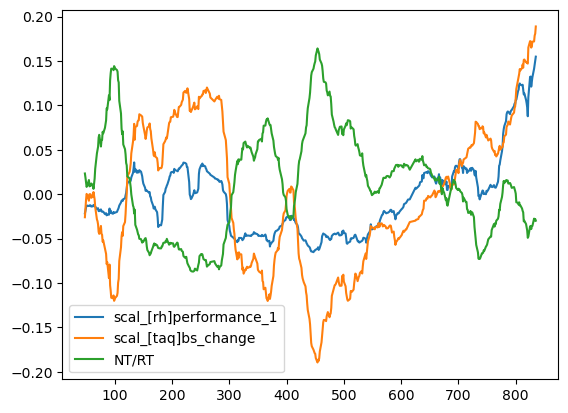

<a class="anchor" id="ntrt_func"></a>

The nt_rt function below is also used in the summary statistics part, which can be found [here](#summary_stats).

In [12]:
# Functions to calc noise trader / retail trader ratio data
from sklearn.preprocessing import MinMaxScaler

def scale_01(df, col_name, name_prefix="scal_"):
   
    # create a MinMaxScaler object
    scaler = MinMaxScaler()

    # fit and transform the data in the 'col_name' column
    # df[f"{name_prefix}{col_name}"] = scaler.fit_transform(df[[col_name]])
    df[f"{name_prefix}{col_name}"] = df.groupby('[rh]ticker')[col_name].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

    return df

# Adds nt_rt column to dataframe
def nt_rt(df):
    # Taking scaled value
    df = scale_01(df, '[rh]performance_1', name_prefix="scal_")
    df = scale_01(df, '[taq]bs_change', name_prefix="scal_")

    # Subtracting average
    df['scal_[rh]performance_1'] = df['scal_[rh]performance_1'] - df['scal_[rh]performance_1'].mean()
    df['scal_[taq]bs_change'] = df['scal_[taq]bs_change'] - df['scal_[taq]bs_change'].mean()
    
    # Calculate NT/RT ratio
    df['NT/RT'] = (1 + df['scal_[rh]performance_1']) / (1 + df['scal_[taq]bs_change']) - 1
    
    return df

**<u>Robustness checks</u>**

I again do robustness checks and check and find the following.

**Fixed effects**

I check if time and firm fixed effects are needed using:

`xtset company_num date_numeric`

`testparm i.date_numeric`

`testparm i.company_num`

I find that this indeed the case, as `Prob > F = 0.0000` is the case for both firm as time fixed effects. To account for this I use the fixed effects in my model with: `i.company_num` `i.date_numeric`.

**Heteroskedasticity**

Using the following code:

`reg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric`
`estat hettest`

I find that heteroskedasticity is assumed for the regression with `Prob > chi2 = 0.0000`. To adjust for this I use `vce(robust)`.

**Autocorrelation**

The following code is used to test for autocorrelation. 

`xtserial rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control`

Auto correlation is found for all four regressions. With `Prob > F = 0.0000`

**Solution**

To solve the above, I use fixed effects and add `vce(robust)` to the regression.

**<u>Twitter</u>**


*Regression for Twitter with VADER sentiment*

In [45]:
def run_twitvader(threshold=0, lag=1, rolling=1):
    custom_code = """
    #reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()
    
    
    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Add NT/RT ratio, column is 'NT/RT'
    df_input = nt_rt(df_input)
    
    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [46]:
run_twitvader(threshold=0, lag=1, rolling=1)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktca
> p_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
Unknown #command
.     reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mrk
> tcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

Linear regression                               Number of obs     =     13,517
                                                F(587, 12929)     =      74.54
                                                Prob > F          =     0.0000
                                                R-squared         =     0.7235
                       

      21537  |   .0028685   .0331964     0.09   0.931                  .000668
      21538  |   .0443531   .0336825     1.32   0.188                 .0103293
      21539  |   .0215642   .0316989     0.68   0.496                 .0049207
      21542  |   .0426634   .0342627     1.25   0.213                 .0095308
      21544  |  -.0079051   .0361553    -0.22   0.827                -.0017659
      21545  |   -.019802   .0326774    -0.61   0.545                -.0044237
      21546  |   .0123024   .0394906     0.31   0.755                 .0027483
      21549  |   .0290388   .0416886     0.70   0.486                 .0064871
      21551  |  -.0187297   .0311954    -0.60   0.548                -.0042739
      21552  |   -.074252   .0315307    -2.35   0.019                -.0169436
      21553  |   .0379509   .0346686     1.09   0.274                  .008478
      21556  |  -.0546404   .0327136    -1.67   0.095                -.0122063
      21557  |  -.0684649   .0307783    -2.22   0.02

      21767  |  -.0353092   .0306887    -1.15   0.250                -.0082231
      21768  |  -.0300992   .0315635    -0.95   0.340                -.0070097
      21769  |  -.0383861   .0316721    -1.21   0.226                -.0089396
      21770  |  -.0245481   .0313381    -0.78   0.433                -.0057169
      21773  |  -.0092649   .0322818    -0.29   0.774                -.0020697
      21774  |   .0072402    .034529     0.21   0.834                 .0016174
      21775  |  -.0878789    .032811    -2.68   0.007                -.0200531
      21776  |  -.0179032    .048931    -0.37   0.714                -.0040854
      21777  |  -.0266147   .0323548    -0.82   0.411                -.0059456
      21780  |   .0072223   .0321847     0.22   0.822                 .0016134
      21781  |  -.0059217    .031726    -0.19   0.852                -.0013229
      21782  |   .0016032   .0331054     0.05   0.961                 .0003658
      21783  |   -.025983   .0325497    -0.80   0.42

      21958  |  -.0213873   .0316443    -0.68   0.499                -.0049808
      21959  |  -.0277223   .0310955    -0.89   0.373                -.0064562
      21963  |  -.0804827   .0318589    -2.53   0.012                -.0183654
      21964  |  -.0485018   .0309679    -1.57   0.117                -.0112954
      21965  |  -.0331072    .033707    -0.98   0.326                -.0077102
      21966  |  -.0397817   .0320155    -1.24   0.214                -.0092647
      21969  |  -.1028471   .0337874    -3.04   0.002                -.0234687
      21970  |  -.0466097   .0316951    -1.47   0.141                -.0106359
      21971  |  -.0177685    .032345    -0.55   0.583                -.0040546
      21972  |   -.133753   .0338374    -3.95   0.000                -.0305212
      21973  |  -.0686351   .0322419    -2.13   0.033                -.0156619
      21976  |  -.0748938   .0304466    -2.46   0.014                -.0170901
      21977  |   -.000674   .0361299    -0.02   0.98

      22116  |  -.0479007   .0365529    -1.31   0.190                -.0109305
      22117  |  -.0215276   .0349314    -0.62   0.538                -.0050135
      22118  |   -.045199   .0310525    -1.46   0.146                -.0105263
      22119  |  -.0775635   .0327959    -2.37   0.018                -.0180636
      22120  |  -.0451895   .0348504    -1.30   0.195                -.0105241
      22123  |  -.0196157   .0320894    -0.61   0.541                -.0045682
      22124  |  -.0552754   .0316339    -1.75   0.081                -.0128729
      22125  |  -.0543939   .0344556    -1.58   0.114                -.0126677
      22126  |  -.0915644   .0336084    -2.72   0.006                -.0213242
      22127  |  -.0802689   .0345059    -2.33   0.020                -.0186936
      22130  |  -.0250228   .0384047    -0.65   0.515                  -.00559
      22131  |  -.0500594   .0347179    -1.44   0.149                -.0114231
      22132  |  -.0319978   .0373688    -0.86   0.39



*Regression for Twitter with finBERT sentiment*

In [47]:
def run_twitfinbert(threshold=0, lag=1, rolling=1):
    custom_code = """
    #reg NTRT twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    reg NTRT twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()
    
    
    sentiment_col = '[twit][f2BERT]method_1'
    volume_col = '[twit][f2BERT]total'
    interaction_col = '[f2BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Add NT/RT ratio, column is 'NT/RT'
    df_input = nt_rt(df_input)
    
    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [48]:
run_twitfinbert(threshold=0, lag=1, rolling=1)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #reg NTRT twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crsp
> mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) be
> ta
Unknown #command
.     reg NTRT twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspl
> og_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust)
>  beta

Linear regression                               Number of obs     =     10,910
                                                F(587, 10322)     =      57.72
                                                Prob > F          =     0.0000
                                                R-squared         =     0.7095
     

      21532  |  -.0027597   .0379011    -0.07   0.942                -.0006254
      21535  |   .0347707   .0379894     0.92   0.360                 .0078798
      21536  |   .0543144   .0389679     1.39   0.163                 .0129735
      21537  |   .0074451   .0379786     0.20   0.845                 .0017334
      21538  |   .0493279   .0383207     1.29   0.198                 .0111788
      21539  |   .0347735   .0353904     0.98   0.326                  .008096
      21542  |   .0445241   .0395996     1.12   0.261                 .0098063
      21544  |  -.0082027   .0405472    -0.20   0.840                -.0017528
      21545  |  -.0163782   .0376113    -0.44   0.663                -.0036073
      21546  |   .0253072   .0473005     0.54   0.593                 .0055738
      21549  |   .0323203   .0495162     0.65   0.514                 .0073245
      21551  |  -.0140513   .0344505    -0.41   0.683                -.0032714
      21552  |  -.0813674   .0354885    -2.29   0.02

      21745  |   .0212827   .0405256     0.53   0.599                 .0046875
      21746  |  -.0028707   .0351639    -0.08   0.935                -.0006506
      21747  |   .0227388   .0442873     0.51   0.608                 .0052941
      21748  |   .0565714   .0826503     0.68   0.494                 .0128204
      21749  |  -.0103041   .0358243    -0.29   0.774                -.0022694
      21752  |  -.0094032   .0340439    -0.28   0.782                -.0020093
      21753  |  -.0046206   .0427715    -0.11   0.914                -.0010177
      21754  |   .0192758   .0381961     0.50   0.614                 .0042454
      21755  |  -.0146844   .0376613    -0.39   0.697                -.0033278
      21756  |  -.0028702   .0369499    -0.08   0.938                -.0006505
      21759  |  -.0064466   .0367525    -0.18   0.861                -.0016148
      21760  |  -.0395268   .0350261    -1.13   0.259                -.0099012
      21761  |  -.0586565   .0356803    -1.64   0.10

      21938  |  -.0421847   .0379559    -1.11   0.266                  -.00956
      21941  |  -.0467444   .0414868    -1.13   0.260                -.0108831
      21942  |  -.0277448    .034893    -0.80   0.427                -.0062876
      21943  |   -.055094   .0384986    -1.43   0.152                -.0124855
      21944  |  -.0731988    .042815    -1.71   0.087                -.0165885
      21945  |   -.061713   .0377027    -1.64   0.102                -.0139855
      21948  |  -.0370515    .041061    -0.90   0.367                -.0079172
      21949  |  -.0307565   .0372395    -0.83   0.409                 -.006774
      21950  |  -.0680954   .0420966    -1.62   0.106                -.0149978
      21951  |  -.0405116    .034095    -1.19   0.235                -.0089226
      21952  |  -.0570122   .0359521    -1.59   0.113                -.0125568
      21955  |  -.0442191   .0338873    -1.30   0.192                -.0108225
      21956  |    -.02832   .0367145    -0.77   0.44

      22098  |  -.0082703   .0346665    -0.24   0.811                -.0020717
      22102  |   .0441455   .0454929     0.97   0.332                 .0097229
      22103  |   -.031561   .0427564    -0.74   0.460                 -.006744
      22104  |  -.0413175    .038373    -1.08   0.282                -.0088288
      22105  |  -.0757189    .041331    -1.83   0.067                -.0161797
      22106  |  -.0732484   .0365149    -2.01   0.045                -.0156518
      22109  |   .0042708   .0411102     0.10   0.917                 .0010698
      22110  |  -.0700943   .0346635    -2.02   0.043                 -.017952
      22111  |   -.018064   .0364616    -0.50   0.620                -.0046264
      22112  |  -.0628571   .0398955    -1.58   0.115                -.0160985
      22113  |  -.0568702   .0349512    -1.63   0.104                -.0142457
      22116  |  -.0279387   .0368227    -0.76   0.448                -.0066734
      22117  |  -.0424244    .036199    -1.17   0.24

**<u>Reddit</u>**


*Regression for Reddit with VADER sentiment*

In [49]:
def run_redvader(threshold=0, lag=1, rolling=1):
    custom_code = """
    #reg NTRT redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    reg NTRT redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()
    
    
    sentiment_col = '[red][m2f2s2]method_1'
    volume_col = '[red][m2f2s2]total'
    interaction_col = '[m2f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Add NT/RT ratio, column is 'NT/RT'
    df_input = nt_rt(df_input)
    
    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [50]:
run_redvader(threshold=0, lag=1, rolling=1)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 07may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #reg NTRT redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmr
> ktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
Unknown #command
.     reg NTRT redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crsplog
> _mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) b
> eta

Linear regression                               Number of obs     =     11,160
                                                F(587, 10572)     =      60.20
                                                Prob > F          =     0.0000
                                                R-squared         =     0.7120
            

      21521  |    .010408    .043663     0.24   0.812                 .0023151
      21522  |  -.0713493   .0428066    -1.67   0.096                -.0171395
      21524  |  -.0620371   .0421553    -1.47   0.141                -.0149025
      21525  |  -.0678878   .0405279    -1.68   0.094                 -.016308
      21528  |   .0224452   .0447686     0.50   0.616                 .0047074
      21529  |   .0258775   .0414777     0.62   0.533                 .0054272
      21530  |   .0431403   .0447582     0.96   0.335                 .0101139
      21531  |  -.0101109   .0420198    -0.24   0.810                -.0021857
      21532  |   -.010622   .0437856    -0.24   0.808                -.0024273
      21535  |   .0548446   .0531866     1.03   0.302                 .0121991
      21536  |   .0373218   .0435946     0.86   0.392                 .0093818
      21537  |  -.0130194   .0408574    -0.32   0.750                 -.003201
      21538  |   .0367537    .042781     0.86   0.39

      21818  |   -.010477   .0391233    -0.27   0.789                -.0025168
      21819  |  -.0125382   .0406864    -0.31   0.758                -.0030827
      21822  |   .0154728   .0396068     0.39   0.696                 .0033448
      21823  |  -.0324287   .0393006    -0.83   0.409                -.0072131
      21824  |  -.0685613   .0444531    -1.54   0.123                -.0168566
      21825  |  -.0520378   .0427431    -1.22   0.223                -.0118914
      21826  |   .0068714   .0410875     0.17   0.867                 .0016894
      21829  |  -.0248421   .0406522    -0.61   0.541                -.0052101
      21830  |  -.0292435   .0407742    -0.72   0.473                -.0066826
      21831  |   .0068029   .0401254     0.17   0.865                 .0015949
      21832  |   .0167073   .0413377     0.40   0.686                 .0039169
      21833  |   .0774461   .0477803     1.62   0.105                 .0172264
      21836  |  -.0244778   .0401986    -0.61   0.54

      21991  |   .0517948   .0485074     1.07   0.286                   .01302
      21992  |   .0527785   .0484328     1.09   0.276                 .0132673
      21993  |   .0144702   .0483494     0.30   0.765                 .0035577
      21994  |    .042563   .0476007     0.89   0.371                  .010929
      21997  |   .0284904   .0522503     0.55   0.586                 .0066793
      21998  |  -.0232976   .0492625    -0.47   0.636                -.0058565
      21999  |  -.0086468   .0511253    -0.17   0.866                -.0020771
      22000  |  -.0642288   .0465891    -1.38   0.168                 -.015429
      22001  |  -.0661223   .0409599    -1.61   0.106                -.0166216
      22004  |  -.0560875   .0460844    -1.22   0.224                -.0134733
      22005  |   -.043943   .0415065    -1.06   0.290                 -.010302
      22006  |  -.0623859   .0400344    -1.56   0.119                -.0153383
      22007  |  -.0200712   .0408315    -0.49   0.62


. 
.     
. 


*Regression for Reddit with finBERT sentiment*

In [51]:
def run_redfinbert(threshold=0, lag=1, rolling=1):
    custom_code = """
    reg NTRT redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()
    
    
    sentiment_col = '[red][m2f2BERT]method_1'
    volume_col = '[red][m2f2BERT]total'
    interaction_col = '[m2f2BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Add NT/RT ratio, column is 'NT/RT'
    df_input = nt_rt(df_input)
    
    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [52]:
run_redfinbert(threshold=0, lag=1, rolling=1)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 07may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     reg NTRT redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol c
> rsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(rob
> ust) beta

Linear regression                               Number of obs     =      8,837
                                                F(587, 8249)      =      45.60
                                                Prob > F          =     0.0000
                                                R-squared         =     0.6884
                                                Root MSE          =     .10088

------------------------------------------------------------------------------
             |          

      21433  |  -.0714323   .0511273    -1.40   0.162                -.0173924
      21434  |  -.0586073   .0488271    -1.20   0.230                -.0151336
      21437  |  -.0505714   .0531791    -0.95   0.342                -.0102124
      21438  |  -.0525377   .0505761    -1.04   0.299                -.0127919
      21439  |  -.0643133   .0512109    -1.26   0.209                -.0170611
      21440  |   -.029224   .0549325    -0.53   0.595                -.0075463
      21441  |  -.0615902    .049739    -1.24   0.216                 -.014996
      21444  |  -.0692782   .0515937    -1.34   0.179                -.0163332
      21445  |  -.0958615   .0529907    -1.81   0.070                -.0254303
      21446  |  -.0873145   .0589166    -1.48   0.138                -.0198886
      21447  |   .0181351   .0573263     0.32   0.752                 .0046829
      21448  |  -.0642643   .0552597    -1.16   0.245                -.0165944
      21451  |  -.0783363   .0500433    -1.57   0.11

      21677  |  -.0399146   .0481322    -0.83   0.407                -.0090918
      21678  |  -.0327738   .0490164    -0.67   0.504                -.0079798
      21679  |  -.0715205   .0480913    -1.49   0.137                -.0168619
      21682  |  -.1016824   .0534164    -1.90   0.057                -.0214457
      21683  |  -.0434327   .0508734    -0.85   0.393                -.0098932
      21684  |  -.0379695   .0477496    -0.80   0.427                -.0089518
      21685  |  -.0480929    .049969    -0.96   0.336                -.0124186
      21686  |  -.0482404   .0504641    -0.96   0.339                -.0121064
      21689  |  -.0401489   .0521917    -0.77   0.442                -.0091452
      21690  |  -.0370745   .0476397    -0.78   0.436                -.0084449
      21691  |  -.0344591   .0483902    -0.71   0.476                -.0078491
      21692  |  -.0577689   .0512117    -1.13   0.259                -.0140656
      21693  |   .0089076   .0512438     0.17   0.86

      21864  |  -.0174501   .0544562    -0.32   0.749                -.0041141
      21865  |  -.0135184   .0522446    -0.26   0.796                -.0032915
      21866  |  -.0186785   .0551833    -0.34   0.735                -.0049551
      21867  |   .0053602   .0491358     0.11   0.913                 .0011766
      21868  |  -.0316128   .0502474    -0.63   0.529                -.0079335
      21871  |  -.0451941   .0536684    -0.84   0.400                -.0106551
      21872  |  -.0408495   .0496161    -0.82   0.410                -.0102516
      21873  |  -.0224592   .0479796    -0.47   0.640                -.0057994
      21874  |  -.0408781   .0494979    -0.83   0.409                 -.009953
      21875  |  -.0247115   .0499186    -0.50   0.621                -.0058261
      21878  |    -.01964   .0475316    -0.41   0.679                -.0041422
      21879  |  -.0536962   .0528526    -1.02   0.310                -.0108435
      21880  |  -.0051498   .0530604    -0.10   0.92

      22039  |  -.0939501   .0489212    -1.92   0.055                -.0242599
      22040  |  -.0711797   .0481967    -1.48   0.140                -.0198494
      22041  |  -.0926699   .0488749    -1.90   0.058                -.0245836
      22042  |  -.0553238   .0481934    -1.15   0.251                -.0157899
      22043  |  -.0801576   .0504973    -1.59   0.112                 -.022353
      22046  |  -.0068979   .0534966    -0.13   0.897                -.0017812
      22047  |  -.0821523   .0487252    -1.69   0.092                -.0229093
      22048  |  -.0865204   .0571156    -1.51   0.130                -.0217131
      22049  |   -.077664   .0513149    -1.51   0.130                -.0200545
      22050  |   -.040028   .0491658    -0.81   0.416                -.0103361
      22053  |   .0059492   .0524566     0.11   0.910                 .0015782
      22054  |  -.0360169   .0496959    -0.72   0.469                -.0098023
      22055  |  -.0068315   .0530143    -0.13   0.89

### Non strict filter and lookback mean effects <a class="anchor" id="strict_filter"></a>

[Go back up](#top)

In [24]:
def run_twitvader_lenient(threshold=0):
    custom_code = """
    reg rhperformance_1 twitf1s2method_1 twitf1s2total f1s2interact_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f1s2]method_1'
    volume_col = '[twit][f1s2]total'
    interaction_col = '[f1s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [25]:
run_twitvader_lenient(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     reg rhperformance_1 twitf1s2method_1 twitf1s2total f1s2interact_sent_vol 
> crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(ro
> bust) beta

Linear regression                               Number of obs     =     13,517
                                                F(587, 12929)     =       3.17
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1012
                                                Root MSE          =     .01149

------------------------------------------------------------------------------
             |         

      21410  |  -.0009574   .0035647    -0.27   0.788                -.0033281
      21411  |   .0006613   .0037216     0.18   0.859                 .0023482
      21412  |  -.0003318   .0044304    -0.07   0.940                -.0011535
      21413  |  -.0013012   .0036002    -0.36   0.718                -.0046206
      21416  |   .0041307   .0062038     0.67   0.506                 .0146681
      21417  |   .0051754   .0070395     0.74   0.462                 .0187561
      21418  |  -.0018394   .0036945    -0.50   0.619                -.0066661
      21419  |  -.0025865   .0037022    -0.70   0.485                -.0093736
      21420  |  -.0001922   .0045359    -0.04   0.966                -.0006965
      21423  |   .0087393   .0094076     0.93   0.353                 .0316719
      21424  |   .0006966   .0037371     0.19   0.852                 .0025244
      21425  |    .001821    .005751     0.32   0.752                 .0065993
      21426  |   .0039584   .0063719     0.62   0.53

      21630  |  -.0011403   .0034689    -0.33   0.742                -.0041326
      21633  |   .0003414   .0034002     0.10   0.920                 .0012124
      21634  |  -.0001414   .0034558    -0.04   0.967                -.0005023
      21635  |  -.0008814   .0035676    -0.25   0.805                -.0031943
      21636  |  -.0045194    .003976    -1.14   0.256                -.0163787
      21637  |  -.0048854   .0036456    -1.34   0.180                -.0177052
      21640  |  -.0027826   .0035506    -0.78   0.433                -.0100842
      21641  |  -.0002394   .0038837    -0.06   0.951                -.0008677
      21642  |  -.0041128   .0033699    -1.22   0.222                -.0149049
      21643  |  -.0002437   .0048746    -0.05   0.960                 -.000883
      21644  |  -.0030551   .0034856    -0.88   0.381                 -.011072
      21647  |  -.0015205   .0036359    -0.42   0.676                -.0053991
      21648  |  -.0022698    .003344    -0.68   0.49

      21805  |  -.0032326   .0033243    -0.97   0.331                -.0117152
      21808  |  -.0027171   .0033408    -0.81   0.416                -.0098471
      21809  |   -.003112   .0032818    -0.95   0.343                -.0110506
      21810  |  -.0033543    .003291    -1.02   0.308                -.0121561
      21811  |  -.0023026   .0033056    -0.70   0.486                -.0083449
      21812  |  -.0015325   .0033172    -0.46   0.644                -.0055539
      21815  |  -.0027147   .0033272    -0.82   0.415                -.0098382
      21816  |  -.0025571   .0034262    -0.75   0.455                -.0092673
      21817  |   -.002208    .003324    -0.66   0.507                 -.008002
      21818  |  -.0025918   .0033412    -0.78   0.438                -.0093927
      21819  |  -.0022842   .0033333    -0.69   0.493                 -.008278
      21822  |  -.0015956   .0033107    -0.48   0.630                -.0056658
      21823  |  -.0021613   .0032927    -0.66   0.51

      21984  |   .0043053   .0040076     1.07   0.283                 .0152881
      21985  |  -1.21e-06   .0043153    -0.00   1.000                -4.30e-06
      21986  |   -.004208   .0053249    -0.79   0.429                -.0149424
      21987  |    .012191   .0056163     2.17   0.030                 .0432899
      21990  |   .0194011   .0073359     2.64   0.008                 .0688928
      21991  |   .0093505   .0067164     1.39   0.164                 .0332035
      21992  |   .0134415   .0078777     1.71   0.088                 .0477305
      21993  |   .0072161   .0054146     1.33   0.183                 .0256242
      21994  |   .0133388   .0056051     2.38   0.017                 .0473657
      21997  |   .0121219   .0055324     2.19   0.028                 .0430446
      21998  |   .0080798    .005229     1.55   0.122                 .0286912
      21999  |    .012157   .0059646     2.04   0.042                 .0431693
      22000  |     .00918   .0064569     1.42   0.15


.     
. 


*Regression for Twitter with finBERT sentiment*

In [26]:
def run_twitfinbert_lenient(threshold=0):
    custom_code = """
    reg rhperformance_1 twitf1BERTmethod_1 twitf1BERTtotal f1BERTinteract_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f1BERT]method_1'
    volume_col = '[twit][f1BERT]total'
    interaction_col = '[f1BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

    df_input = df_input[df_input[volume_col] > threshold]


    Stata.run(df_input, stata_code)


In [27]:
run_twitfinbert_lenient(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     reg rhperformance_1 twitf1BERTmethod_1 twitf1BERTtotal f1BERTinteract_sen
> t_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, 
> vce(robust) beta

Linear regression                               Number of obs     =     10,910
                                                F(587, 10322)     =       2.94
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1234
                                                Root MSE          =     .01154

------------------------------------------------------------------------------
             |   

      21552  |      .0013   .0021967     0.59   0.554                 .0046386
      21553  |  -.0056055   .0030653    -1.83   0.067                -.0194968
      21556  |   .0029885   .0024025     1.24   0.214                 .0103943
      21557  |   .0009766   .0021178     0.46   0.645                 .0033966
      21558  |  -.0000375   .0018866    -0.02   0.984                 -.000137
      21559  |   .0002001   .0019677     0.10   0.919                 .0007317
      21560  |   .0000547   .0018999     0.03   0.977                 .0002093
      21563  |   .0019348   .0019732     0.98   0.327                 .0072403
      21564  |   .0017763   .0028619     0.62   0.535                 .0066471
      21565  |   .0030524   .0022349     1.37   0.172                 .0114225
      21566  |    .001079   .0018877     0.57   0.568                 .0040376
      21567  |   .0058462    .006286     0.93   0.352                 .0213753
      21571  |   .0041802   .0031921     1.31   0.19

      21777  |   .0006154   .0018305     0.34   0.737                 .0021403
      21780  |  -.0011675   .0018859    -0.62   0.536                -.0039525
      21781  |  -.0007122   .0018999    -0.37   0.708                -.0023434
      21782  |   .0003059   .0020003     0.15   0.878                 .0010065
      21783  |  -.0001014   .0020661    -0.05   0.961                -.0003433
      21784  |    .001164   .0021822     0.53   0.594                 .0039407
      21787  |   .0019958    .001994     1.00   0.317                 .0061691
      21788  |   .0009368   .0020397     0.46   0.646                 .0029903
      21789  |   .0017179   .0022413     0.77   0.443                 .0056524
      21790  |  -.0002462   .0026024    -0.09   0.925                  -.00081
      21791  |   .0011856    .002355     0.50   0.615                  .003901
      21795  |   .0032278    .002269     1.42   0.155                  .009639
      21796  |   -.000047   .0019157    -0.02   0.98

      21977  |   .0073592   .0032927     2.24   0.025                 .0249147
      21978  |   .0020954   .0020896     1.00   0.316                 .0074771
      21979  |   .0033204   .0028638     1.16   0.246                 .0115487
      21980  |   .0031947   .0025262     1.26   0.206                 .0113999
      21983  |   .0000171   .0031227     0.01   0.996                 .0000595
      21984  |   .0094597   .0032568     2.90   0.004                 .0329021
      21985  |   .0046714   .0039415     1.19   0.236                 .0162476
      21986  |   .0004666   .0050696     0.09   0.927                  .001665
      21987  |   .0182816   .0054707     3.34   0.001                 .0652346
      21990  |   .0231108   .0083127     2.78   0.005                 .0803823
      21991  |   .0122987   .0068309     1.80   0.072                 .0449675
      21992  |   .0171483   .0083839     2.05   0.041                 .0626987
      21993  |   .0103636   .0050363     2.06   0.04


.     
. 


**Reddit**

*Regression for Reddit with VADER sentiment*

In [28]:
def run_redvader_lenient(threshold=0):
    custom_code = """
    reg rhperformance_1 redm2f1s2method_1 redm2f1s2total m2f1s2interact_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[red][m2f1s2]method_1'
    volume_col = '[red][m2f1s2]total'
    interaction_col = '[m2f1s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)
    
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code)

In [29]:
run_redvader_lenient(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 07may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     reg rhperformance_1 redm2f1s2method_1 redm2f1s2total m2f1s2interact_sent_
> vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vc
> e(robust) beta

Linear regression                               Number of obs     =     12,457
                                                F(587, 11869)     =       3.04
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1115
                                                Root MSE          =     .01173

------------------------------------------------------------------------------
             |     

      21494  |   -.002134    .004118    -0.52   0.604                -.0072066
      21495  |  -.0026857   .0042302    -0.63   0.526                 -.009491
      21496  |  -.0026619    .004595    -0.58   0.562                -.0092006
      21497  |   .0007078   .0045693     0.15   0.877                 .0023902
      21500  |  -.0000637   .0041492    -0.02   0.988                -.0002151
      21501  |  -.0018717   .0040633    -0.46   0.645                -.0066143
      21502  |  -.0028079   .0040922    -0.69   0.493                -.0092543
      21503  |  -.0018474   .0043725    -0.42   0.673                -.0063853
      21504  |  -.0013083   .0044439    -0.29   0.768                 -.004522
      21507  |  -.0024777     .00408    -0.61   0.544                -.0083673
      21508  |  -.0046541   .0040627    -1.15   0.252                -.0168004
      21509  |  -.0014226   .0040767    -0.35   0.727                -.0049171
      21511  |  -.0030529   .0040661    -0.75   0.45

      21777  |  -.0031994   .0041243    -0.78   0.438                -.0113064
      21780  |  -.0045189   .0040968    -1.10   0.270                -.0148933
      21781  |  -.0042071   .0040429    -1.04   0.298                -.0142078
      21782  |  -.0032233   .0040777    -0.79   0.429                -.0113908
      21783  |   .0004273   .0057687     0.07   0.941                 .0015099
      21784  |  -.0011886   .0043755    -0.27   0.786                -.0042906
      21787  |  -.0008393   .0041894    -0.20   0.841                -.0028342
      21788  |  -.0037293   .0040579    -0.92   0.358                 -.013462
      21789  |  -.0032139   .0041106    -0.78   0.434                -.0113577
      21790  |  -.0034326   .0041964    -0.82   0.413                -.0123909
      21791  |  -.0029783   .0041088    -0.72   0.469                -.0109725
      21795  |  -.0000653   .0041566    -0.02   0.987                -.0002204
      21796  |  -.0030043   .0041661    -0.72   0.47

      21945  |  -.0043347   .0044244    -0.98   0.327                -.0146386
      21948  |  -.0013918   .0062969    -0.22   0.825                -.0047001
      21949  |  -.0008208   .0048595    -0.17   0.866                 -.002837
      21950  |  -.0083494   .0073362    -1.14   0.255                -.0288586
      21951  |  -.0030218   .0042416    -0.71   0.476                -.0104445
      21952  |  -.0032419   .0042091    -0.77   0.441                -.0109482
      21955  |  -.0019802   .0042126    -0.47   0.638                -.0068443
      21956  |  -.0019423   .0043134    -0.45   0.653                 -.006864
      21957  |  -.0038072   .0041173    -0.92   0.355                -.0131592
      21958  |  -.0051255   .0043419    -1.18   0.238                -.0185019
      21959  |  -.0038925   .0041502    -0.94   0.348                -.0134539
      21963  |  -.0035188   .0041862    -0.84   0.401                 -.011883
      21964  |  -.0047538   .0041932    -1.13   0.25


.     
. 


*Regression for Reddit with finBERT sentiment*

In [32]:
def run_redfinbert_lenient(threshold=0):
    custom_code = """
    reg rhperformance_1 redm2f1BERTmethod_1 redm2f1BERTtotal m2f1BERTinteract_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[red][m2f1BERT]method_1'
    volume_col = '[red][m2f1BERT]total'
    interaction_col = '[m2f1BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=1, rolling=1)

    Stata.run(df_input, stata_code)

In [33]:
run_redfinbert_lenient(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (strongly balanced)
 Time variable: date_numeric, 01may2018 to 31aug2020
         Delta: 1 day

. 
.     reg rhperformance_1 redm2f1BERTmethod_1 redm2f1BERTtotal m2f1BERTinteract
> _sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numer
> ic, vce(robust) beta

Linear regression                               Number of obs     =     10,725
                                                F(587, 10137)     =       2.93
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1386
                                                Root MSE          =     .01193

------------------------------------------------------------------------------
             |       

      21462  |   .0000607   .0061363     0.01   0.992                 .0002097
      21465  |  -.0037595   .0054898    -0.68   0.493                -.0123181
      21466  |   .0005141   .0052273     0.10   0.922                 .0017753
      21467  |  -.0079727   .0050193    -1.59   0.112                -.0268376
      21468  |  -.0025018   .0051205    -0.49   0.625                -.0092639
      21469  |   .0058659   .0053829     1.09   0.276                 .0212444
      21472  |  -.0007976   .0049621    -0.16   0.872                -.0026847
      21473  |  -.0055178   .0051614    -1.07   0.285                -.0199836
      21474  |  -.0039505    .004897    -0.81   0.420                -.0132982
      21475  |   -.002341   .0049972    -0.47   0.639                -.0080846
      21476  |  -.0019824   .0050096    -0.40   0.692                -.0073407
      21479  |  -.0009554   .0048606    -0.20   0.844                -.0028579
      21480  |  -.0062515   .0052605    -1.19   0.23

      21745  |   -.001489   .0049235    -0.30   0.762                -.0047416
      21746  |  -.0021807   .0049072    -0.44   0.657                -.0073408
      21747  |    -.00036    .006444    -0.06   0.955                -.0011464
      21748  |  -.0007477   .0056093    -0.13   0.894                  -.00245
      21749  |  -.0032551   .0050107    -0.65   0.516                -.0112414
      21752  |  -.0019927   .0049439    -0.40   0.687                -.0065291
      21753  |  -.0015638   .0050764    -0.31   0.758                -.0057905
      21754  |  -.0024873    .005003    -0.50   0.619                -.0085897
      21755  |  -.0030851   .0049984    -0.62   0.537                -.0106542
      21756  |  -.0035371   .0048672    -0.73   0.467                -.0130974
      21759  |   .0002531   .0052065     0.05   0.961                 .0008294
      21760  |   -.003022   .0049237    -0.61   0.539                -.0104362
      21761  |  -.0039595   .0049928    -0.79   0.42

      22018  |   -.001463    .005224    -0.28   0.779                -.0050525
      22019  |   .0056156   .0078862     0.71   0.476                 .0203379
      22020  |   .0005341   .0055757     0.10   0.924                 .0019344
      22021  |   .0025037    .005846     0.43   0.668                 .0090677
      22022  |   -.003176   .0050626    -0.63   0.530                -.0117604
      22025  |   .0012888   .0057313     0.22   0.822                 .0045605
      22026  |     -.0003   .0052252    -0.06   0.954                -.0010866
      22027  |  -.0036195   .0053305    -0.68   0.497                -.0131085
      22028  |  -.0064476   .0052226    -1.23   0.217                -.0238748
      22029  |  -.0062064   .0054278    -1.14   0.253                -.0224778
      22032  |  -.0038182   .0053326    -0.72   0.474                 -.013511
      22033  |  -.0024047   .0050842    -0.47   0.636                 -.008709
      22034  |  -.0068232   .0059322    -1.15   0.25

### Lag and lookback mean effects <a class="anchor" id="sub-bullet2.3"></a>

[Go back up](#top)

In [11]:
def grab_coefficients(df_input, stata_code, stata_code2, lag, rolling):
    Stata.run(df_input, stata_code)
    print("Now running 'grab_coefficients'")

    r = stata.get_return()
    coefficients = r['r(PT)']
    
    # STATA has a small brain so in order to retrieve r2 different code needs to be ran
    Stata.run(df_input, stata_code2)
    e = stata.get_ereturn()
    
    # Coefficients
    pos = 0
    sentiment = coefficients[0][pos]
    volume = coefficients[1][pos]
    interact = coefficients[2][pos]
    marketcap_control = coefficients[3][pos]
    stockprice_control = coefficients[4][pos]
    r2 = e['e(r2)']
    
    # p-values
    pos = 3
    sentiment_p = coefficients[0][pos]
    volume_p = coefficients[1][pos]
    interact_p = coefficients[2][pos]
    marketcap_control_p = coefficients[3][pos]
    stockprice_control_p = coefficients[4][pos]

    result = [lag, rolling, sentiment, volume, interact, marketcap_control, stockprice_control, r2, sentiment_p, volume_p, interact_p, marketcap_control_p, stockprice_control_p]
    print(f"Now returning coefficients: {result}")
    return result

def regression(stata_code, stata_code2, df, lag, rolling, sentiment_col, volume_col, interaction_col):
    print("Now running 'regression'")
    df_input = df.copy()

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)

    result = grab_coefficients(df_input, stata_code, stata_code2, lag, rolling)
    
    return result

def repeat_reg(stata_code, stata_code2, df, sentiment_col, volume_col, interaction_col, lag_periods, rolling_periods):
    print("Now running 'repeat_reg'")
    # Creating empty df
    result_df = pd.DataFrame(columns=['lag', 'rolling', 'sentiment', 'volume', 'interact', 'marketcap_control', 'stockprice_control', 'r2', 'sentiment_p', 'volume_p', 'interact_p', 'marketcap_control_p', 'stockprice_control_p'])
    # create a list of dataframes to concatenate
    results = []
    
    lag = 1
    for lag_period in range(lag_periods):
        rolling = 1
        for rolling_period in range(rolling_periods):
            print(f"Now doing regression with lag [{lag}] and rolling {rolling}")
            
            result = regression(stata_code, stata_code2, df, lag, rolling, sentiment_col, volume_col, interaction_col)
            results.append(pd.DataFrame([result], columns=result_df.columns))
            print("Saved results to list")
        
            rolling += 1
        lag += 1
                   
    # concatenate the dataframes
    result_df = pd.concat(results, ignore_index=True)
    
    return result_df
    

**Twitter**

In [ ]:
# Calculating lag-rol combinations for Twitter - VADER
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_twitvader.csv"

if save:
    custom_code = """
    reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    """
    stata_code = stata_code_base + custom_code
    stata_code2 = stata_code_base + custom_code2

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, stata_code2, df_input, sentiment_col, volume_col, interaction_col, lag_periods=14, rolling_periods=14)

    result_df.to_csv(save_path)


In [ ]:
# Calculating lag-rol combinations for Twitter - finBERT
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_twitfinbert.csv"

if save:
    custom_code = """
    reg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    """
    stata_code = stata_code_base + custom_code
    stata_code2 = stata_code_base + custom_code2

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2BERT]method_1'
    volume_col = '[twit][f2BERT]total'
    interaction_col = '[f2BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, stata_code2, df_input, sentiment_col, volume_col, interaction_col, lag_periods=14, rolling_periods=14)

    result_df.to_csv(save_path)


**Reddit**

In [ ]:
# Calculating lag-rol combinations for Reddit - VADER
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_redvader.csv"

if save:
    custom_code = """
    reg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    custom_code2 = """areg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    """
    stata_code = stata_code_base + custom_code
    stata_code2 = stata_code_base + custom_code2

    df_input = get_regression_df().copy()

    sentiment_col = '[red][m2f2s2]method_1'
    volume_col = '[red][m2f2s2]total'
    interaction_col = '[m2f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, stata_code2, df_input, sentiment_col, volume_col, interaction_col, lag_periods=14, rolling_periods=14)

    result_df.to_csv(save_path)


In [ ]:
# Calculating lag-rol combinations for Reddit - finBERT
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_redfinbert.csv"

if save:
    custom_code = """
    reg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    custom_code2 = """areg rhperformance_1 redm2f2BERTmethod_1 redm2f2BERTtotal m2f2BERTinteract_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    """
    stata_code = stata_code_base + custom_code
    stata_code2 = stata_code_base + custom_code2

    df_input = get_regression_df().copy()

    sentiment_col = '[red][m2f2BERT]method_1'
    volume_col = '[red][m2f2BERT]total'
    interaction_col = '[m2f2BERT]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, stata_code2, df_input, sentiment_col, volume_col, interaction_col, lag_periods=14, rolling_periods=14)

    result_df.to_csv(save_path)


#### Lag and lookback visualized <a class="anchor" id="sub-bullet2.3.1"></a>

[Go back up](#top)

In [16]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6)
def show_plot(df, column, d1=30, d2=45):
    x = df['rolling']
    y = df['lag']
    z = df[column]

    ax = plt.axes(projection='3d')
    # ax.scatter3D(x, y, z, s=100)
    sc = ax.scatter(x, y, z, c=z, marker='o', s=100, cmap="Spectral")
    plt.colorbar(sc)
    ax.set_xlabel('lookback')
    ax.set_ylabel('lag')
    ax.set_zlabel(column)


    ax.set_title(f'{column} vs lag & lookback')
    ax.view_init(d1, d2);
    plt.show()
    print()
def all_sides(csv_path, column):
    # Read csv
    df = pd.read_csv(csv_path)
    
    # Plot
    show_plot(df, column, 0, 2)
    show_plot(df, column, 0, 88)
    show_plot(df, column, 30, 45)

Result are only plotted for twit vader, results for others are similar.

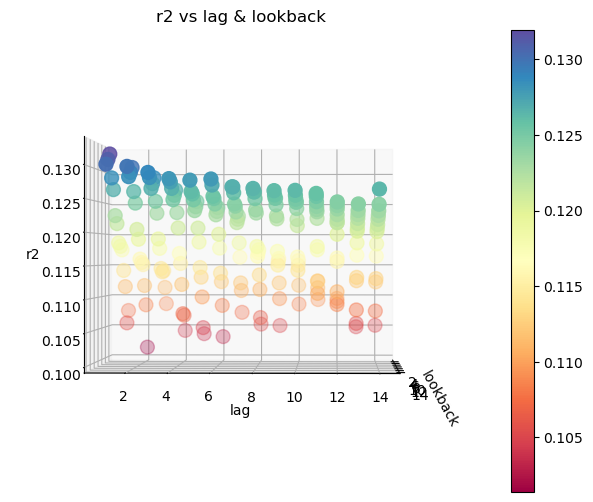

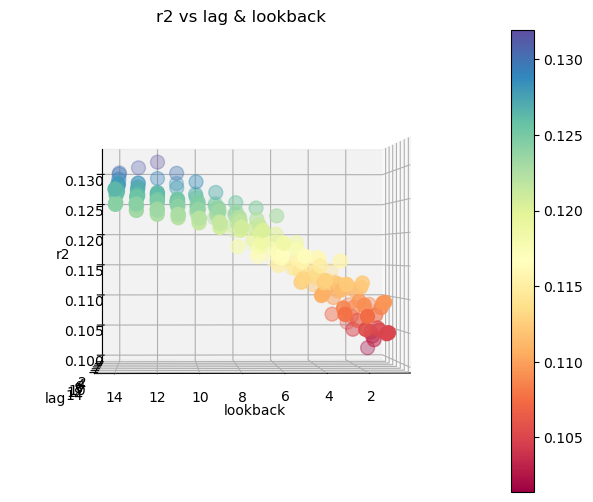

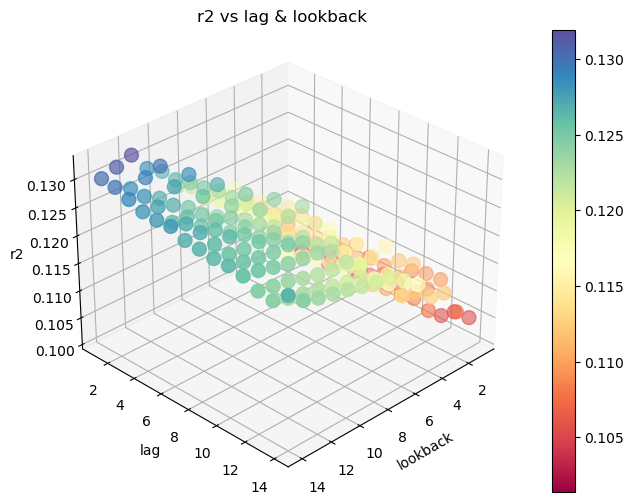

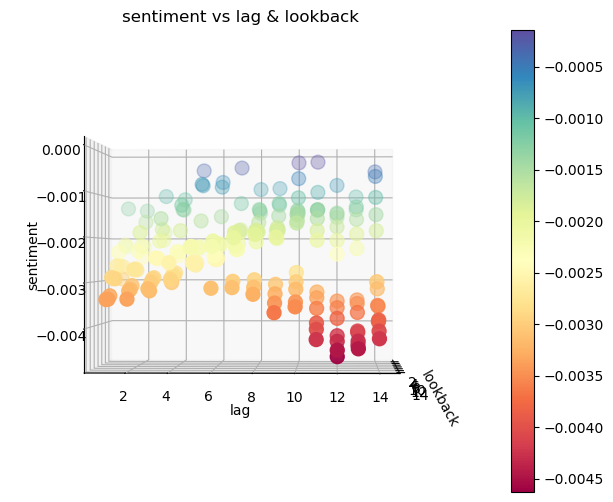

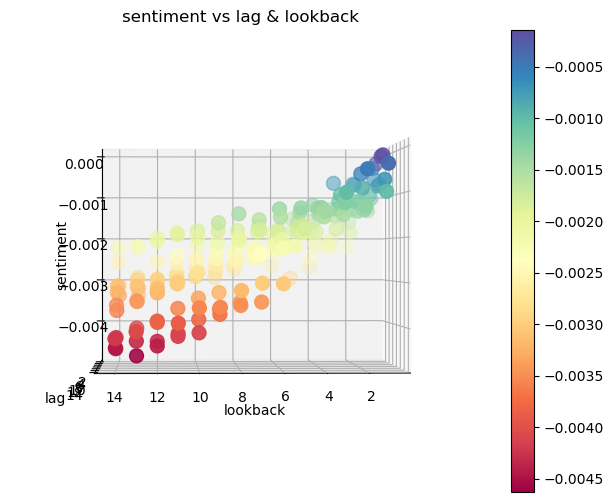

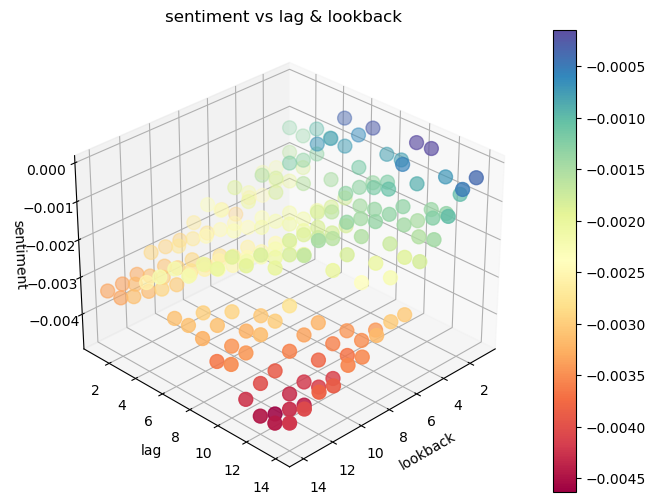

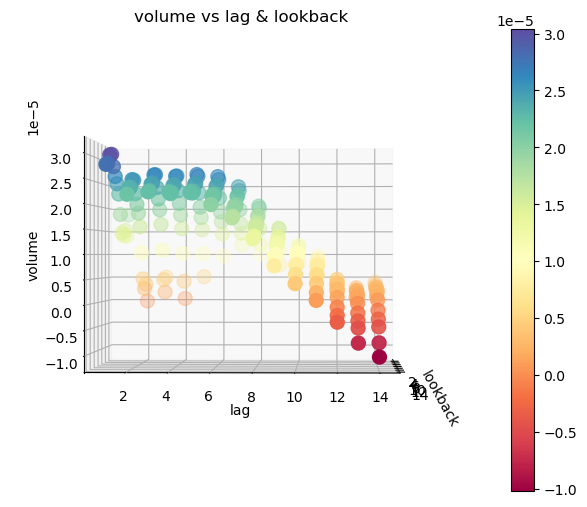

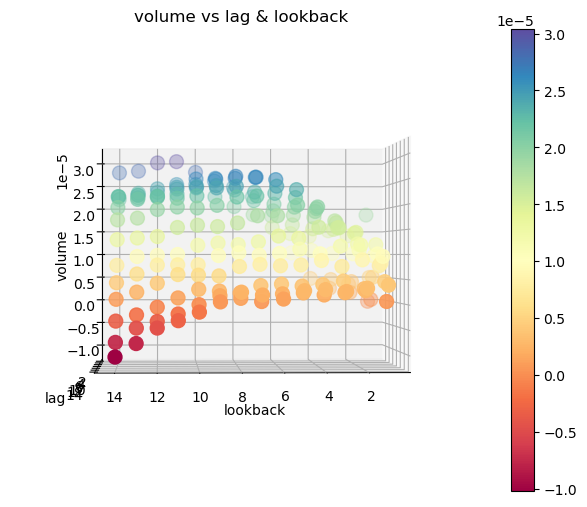

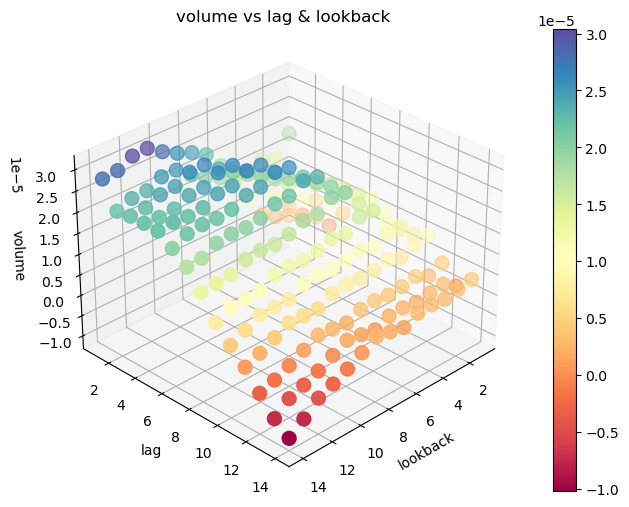

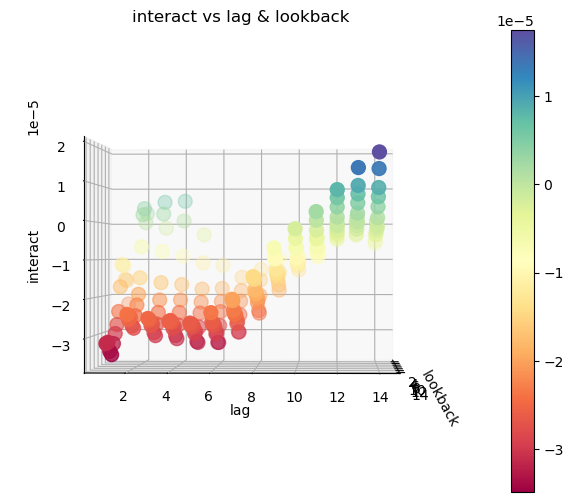

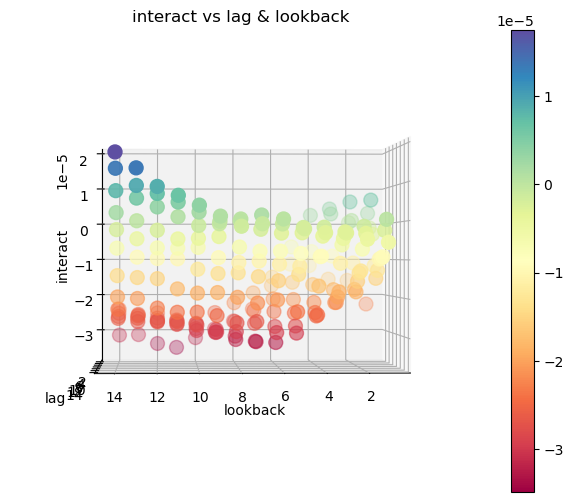

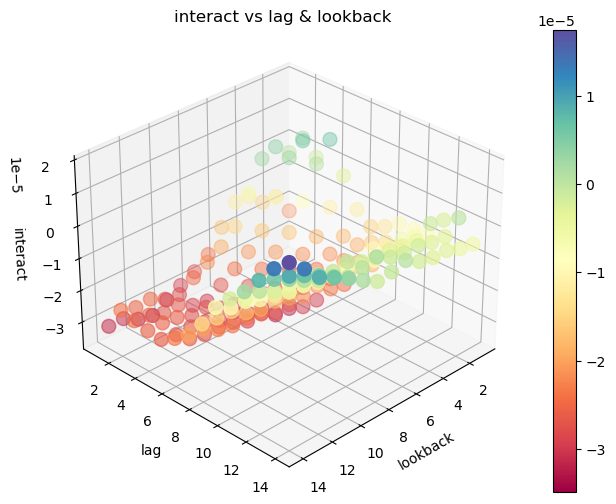

In [54]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_twitvader.csv"
all_sides(csv_path, 'r2')
all_sides(csv_path, 'sentiment')
all_sides(csv_path, 'volume')
all_sides(csv_path, 'interact')


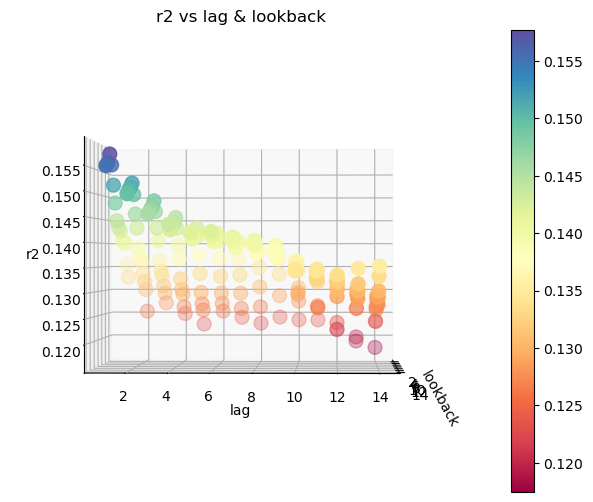

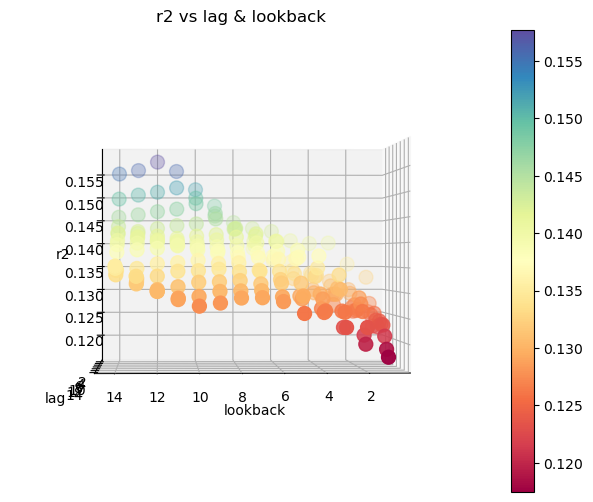

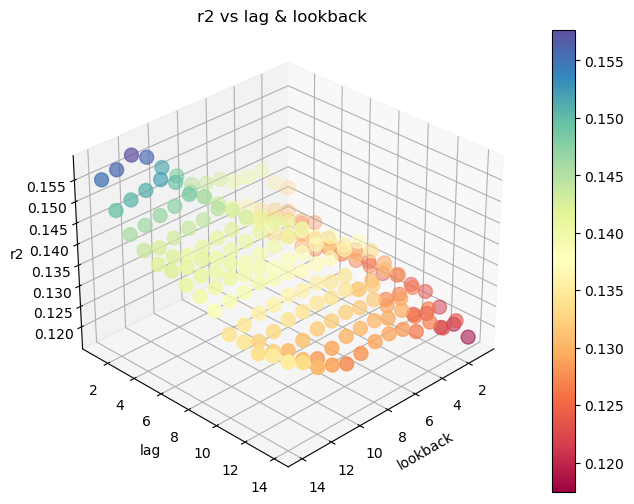

In [20]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_twitfinbert.csv"
all_sides(csv_path, 'r2')

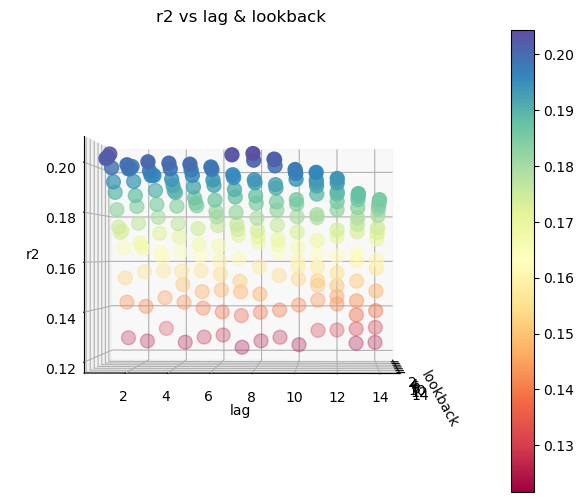

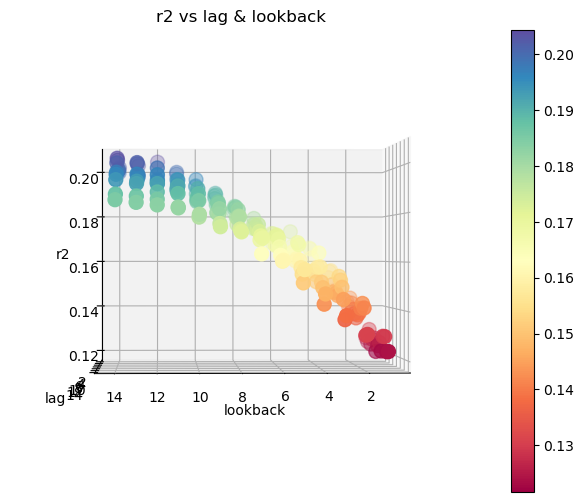

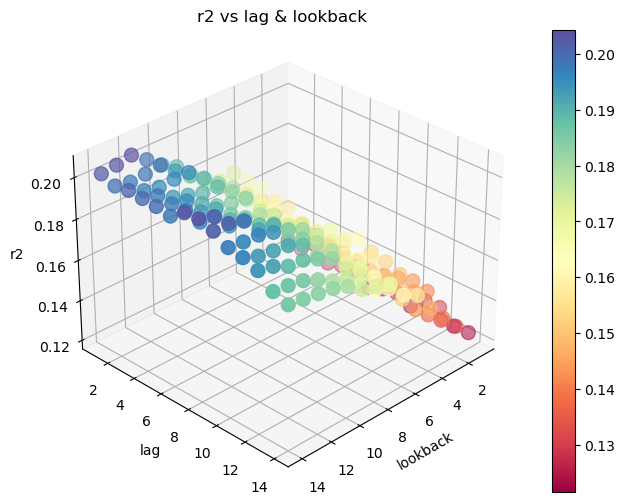

In [21]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_redvader.csv"
all_sides(csv_path, 'r2')

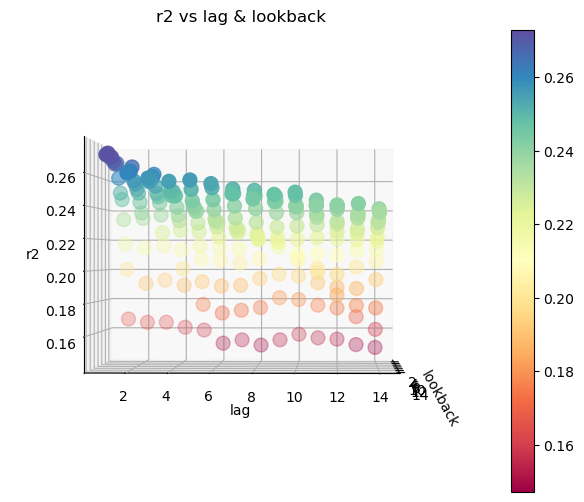

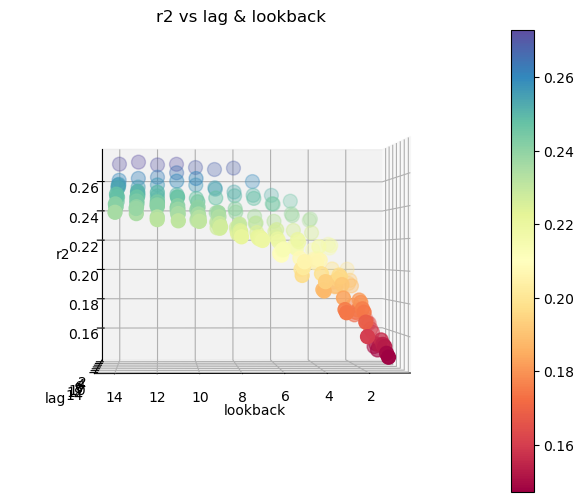

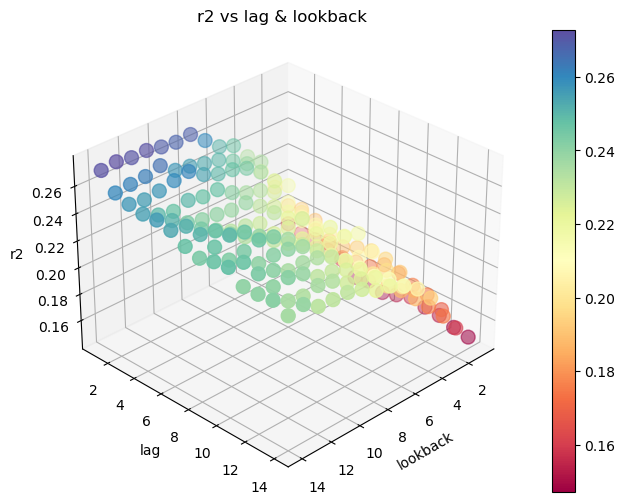

In [22]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\lagrol_redfinbert.csv"
all_sides(csv_path, 'r2')

### Post limit <a class="anchor" id="sub-bullet2.4"></a>

[Go back up](#top)

In [36]:
def grab_coefficients(df_input, stata_code, stata_code2, limit, lag=1, rolling=1):
    Stata.run(df_input, stata_code)
    print("Now running 'grab_coefficients'")

    r = stata.get_return()
    coefficients = r['r(PT)']
    
    # STATA has a small brain so in order to retrieve r2 different code needs to be ran
    Stata.run(df_input, stata_code2)
    e = stata.get_ereturn()
    
    # Coefficients
    pos = 0
    sentiment = coefficients[0][pos]
    volume = coefficients[1][pos]
    interact = coefficients[2][pos]
    marketcap_control = coefficients[3][pos]
    stockprice_control = coefficients[4][pos]
    r2 = e['e(r2)']
    obs_left = e['e(N)']
    
    # p-values
    pos = 3
    sentiment_p = coefficients[0][pos]
    volume_p = coefficients[1][pos]
    interact_p = coefficients[2][pos]
    marketcap_control_p = coefficients[3][pos]
    stockprice_control_p = coefficients[4][pos]

    result = [limit, obs_left, sentiment, volume, interact, marketcap_control, stockprice_control, r2, sentiment_p, volume_p, interact_p, marketcap_control_p, stockprice_control_p]
    print(f"Now returning coefficients: {result}")
    return result

def regression(stata_code, stata_code2, df, sentiment_col, volume_col, interaction_col, limit, lag=1, rolling=1):
    print("Now running 'regression'")
    df_input = df.copy()

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Filtering observations with less than required daily post volume
    df_input = df_input[df_input[volume_col] > limit]

    result = grab_coefficients(df_input, stata_code, stata_code2, limit, lag, rolling)
    
    return result

def repeat_reg(stata_code, stata_code2, df, sentiment_col, volume_col, interaction_col, post_limit_range, lag=1, rolling=1):
    print("Now running 'repeat_reg'")
    # Creating empty df
    result_df = pd.DataFrame(columns=['limit', 'obs_left', 'sentiment', 'volume', 'interact', 'marketcap_control', 'stockprice_control', 'r2', 'sentiment_p', 'volume_p', 'interact_p', 'marketcap_control_p', 'stockprice_control_p'])
    # create a list of dataframes to concatenate
    results = []
    
    # Loops all options from 0 until post_limit_range - 1
    for limit in range(post_limit_range):
        
        print(f"Now doing regression with lag [{lag}] and rolling {rolling}")

        result = regression(stata_code, stata_code2, df, sentiment_col, volume_col, interaction_col, limit=limit)
        results.append(pd.DataFrame([result], columns=result_df.columns))
        print("Saved results to list")
        

    # concatenate the dataframes
    result_df = pd.concat(results, ignore_index=True)
    
    return result_df
    

**Twitter**

In [ ]:
# Calculating lag-rol combinations for Twitter - VADER
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\limit_twitvader.csv"

if save:
    custom_code = """
    reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control i.company_num, vce(robust) absorb(date_numeric)
    """
    stata_code = stata_code_base + custom_code
    stata_code2 = stata_code_base + custom_code2

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, stata_code2, df_input, sentiment_col, volume_col, interaction_col, post_limit_range=501)

    result_df.to_csv(save_path)


#### Graphs <a class="anchor" id="sub-bullet2.4.1"></a>


In [133]:
def plot_graph(df, y1, y2='[taq]price', x='date', x_label="", y1_label="", y2_label="", debug=False):

    fig, ax1 = plt.subplots(figsize=(15, 10))
    
    # Colours    
    colour_dict = {
    'colour_1': "#1f77b4",
    'colour_2': "#ff7f0e",
    'colour_3': "#2ca02c",
    'colour_4': "#d62728",
    'colour_5': "#9467bd",
    'colour_6': "#8c564b",
    'colour_7': "#e377c2"
    }
    
    ax1.plot(df[x], df[y1], label=y1_label, color=colour_dict['colour_1'], lw=2.5) 


            
    
    # General graph setup
    if len(y2) > 0:
        ax2 = ax1.twinx()
        ax2.plot(df[x], df[y2], label=y2_label, color=colour_dict['colour_2'], lw=2.5)
        ax2.set_ylabel(''.join(y2), fontsize=14)
        ax2.tick_params(axis="y")
        ax2.legend(loc = "upper right")
     
    
    ax1.set_xlabel(x_label, fontsize=14)
    ax1.set_ylabel(y1_label, fontsize=14)
    ax1.tick_params(axis="y")
    ax1.grid()
    

    
    ax1.legend(loc = "upper left")
    fig.suptitle(f"{y1_label} and {y2_label} vs {x}", fontsize=20)
    
    fig.autofmt_xdate()
    plt.show()




In [14]:
df = pd.read_csv(r"E:\Users\Christiaan\Large_Files\Thesis\results\limit_twitvader.csv")

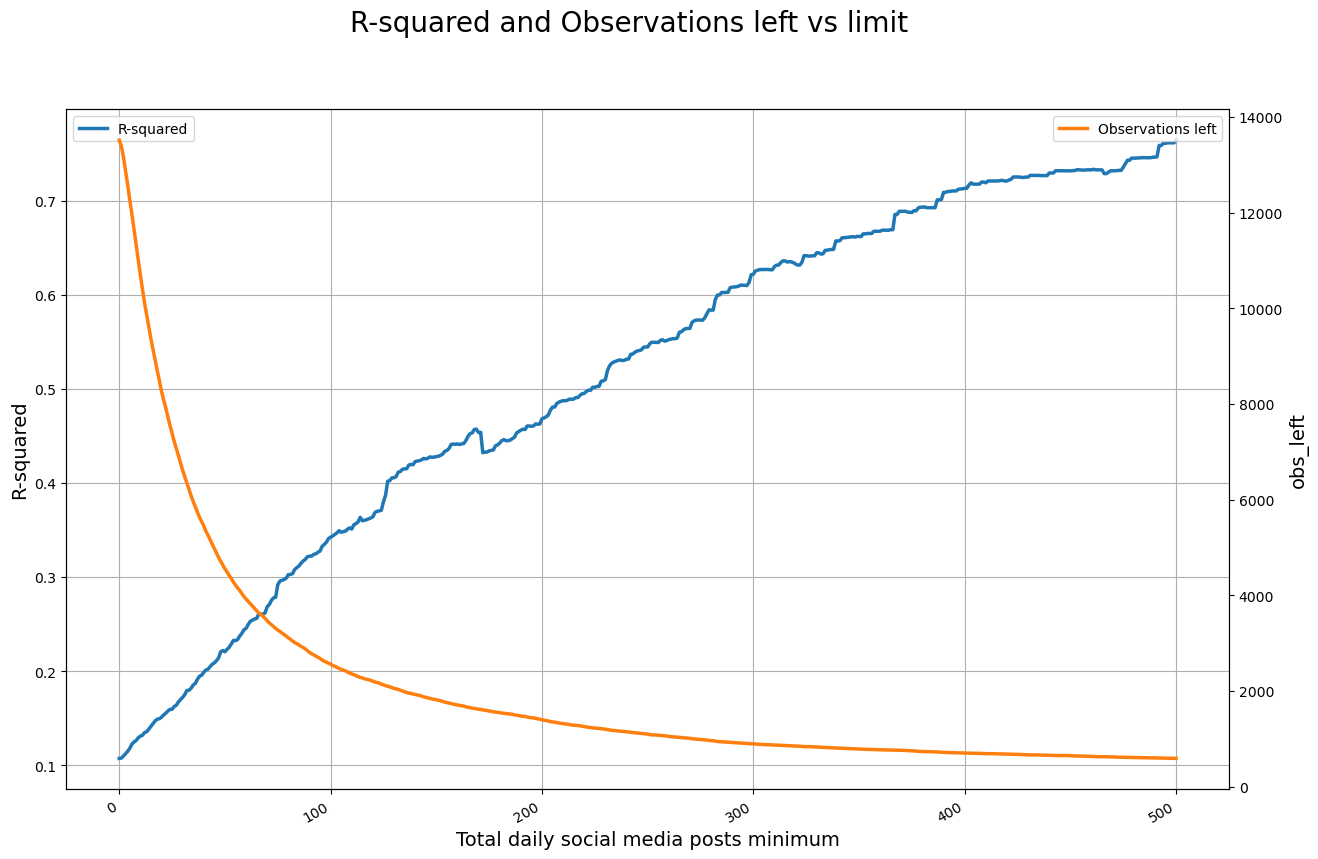

In [106]:
plot_graph(df, y1='r2', y2='obs_left', x='limit', x_label="Total daily social media posts minimum", y1_label="R-squared", y2_label="Observations left", debug=False)

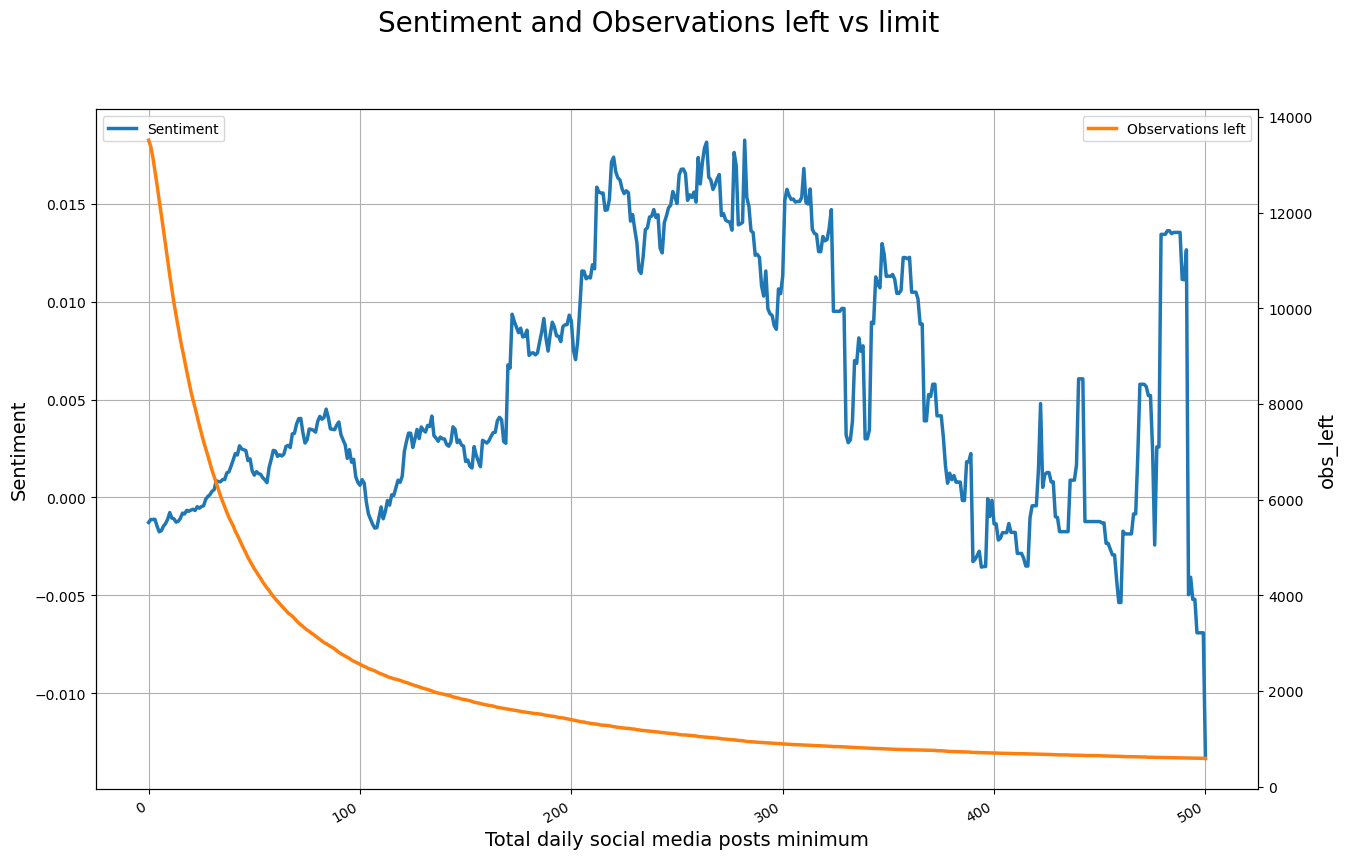

In [109]:
plot_graph(df, y1='sentiment', y2='obs_left', x='limit', x_label="Total daily social media posts minimum", y1_label="Sentiment", y2_label="Observations left", debug=False)

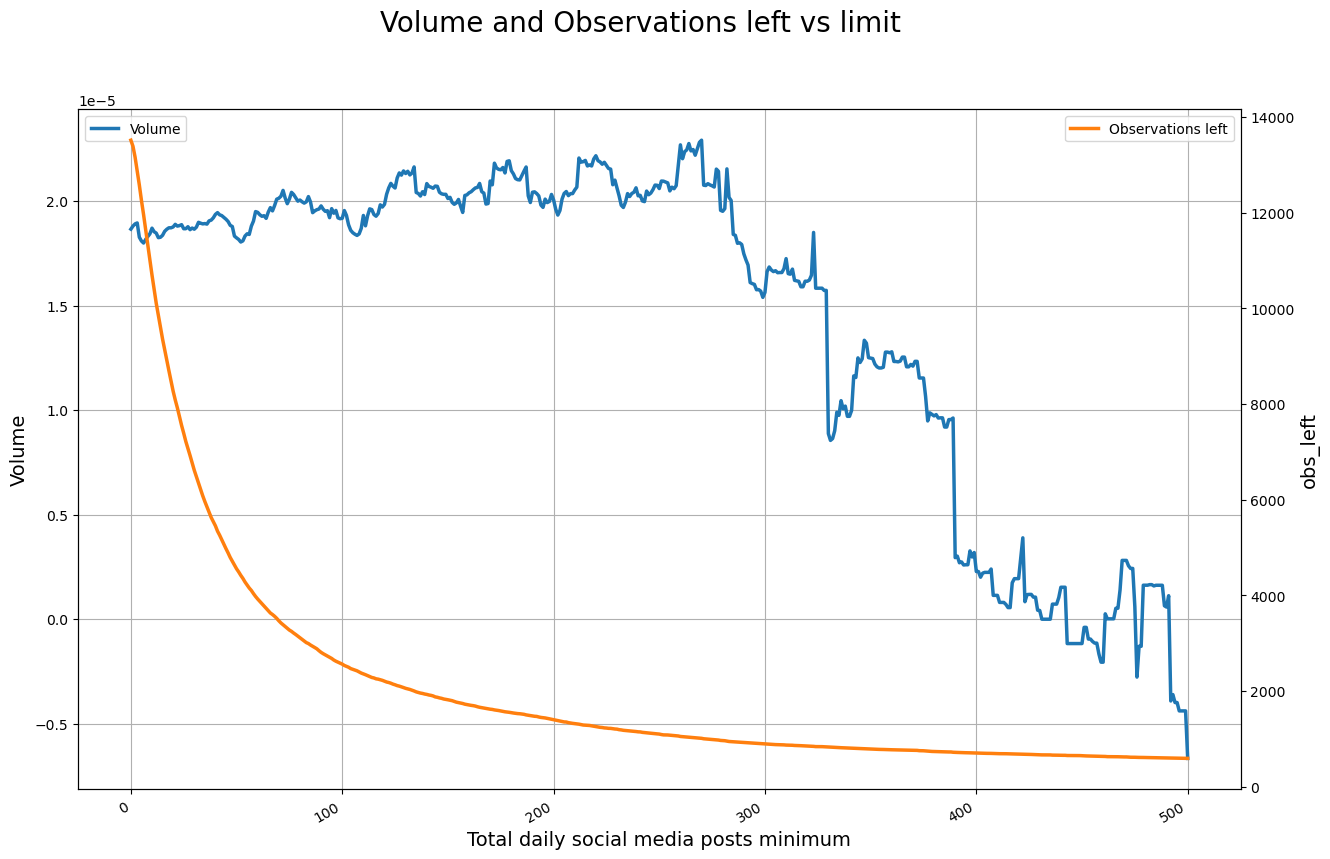

In [115]:
plot_graph(df, y1='volume', y2='obs_left', x='limit', x_label="Total daily social media posts minimum", y1_label="Volume", y2_label="Observations left", debug=False)

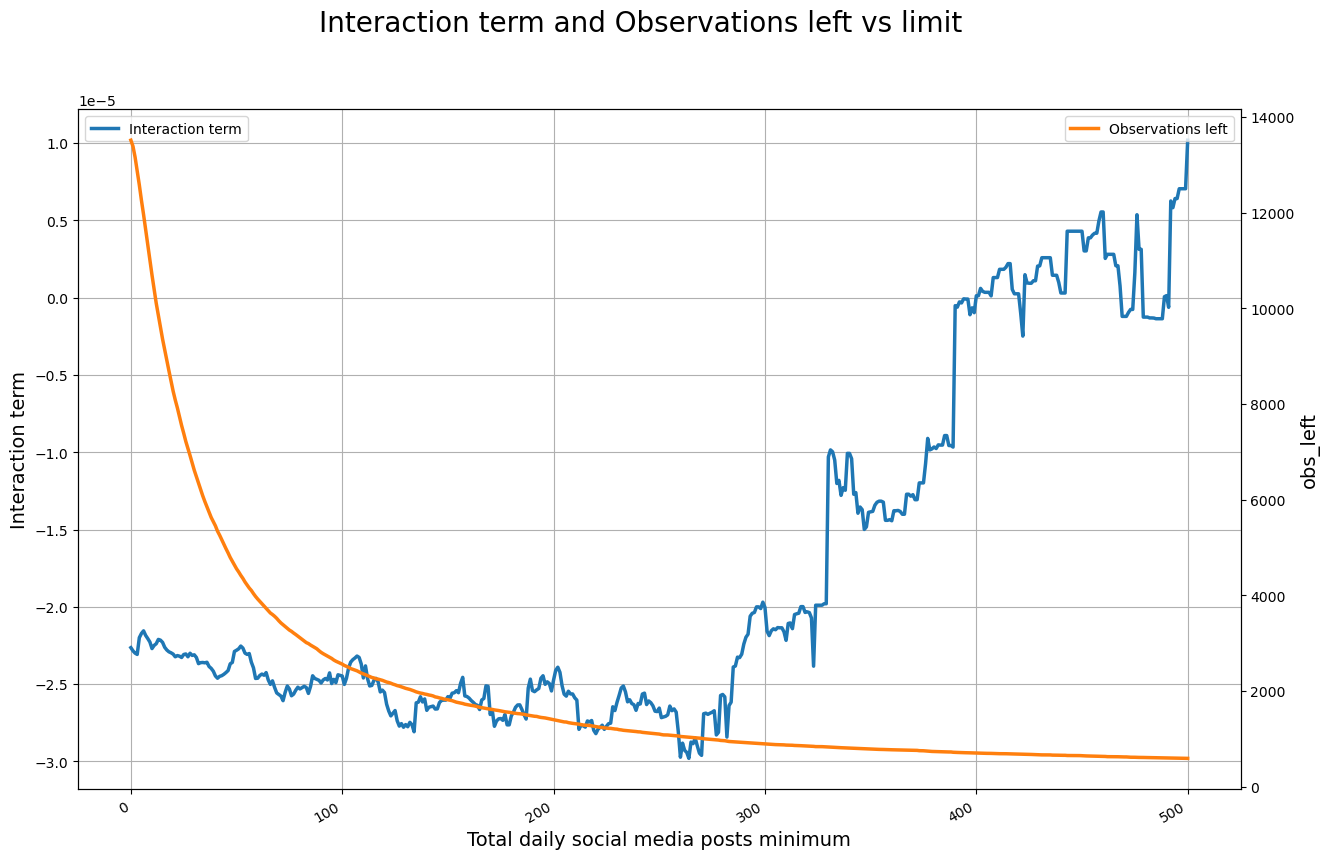

In [19]:
plot_graph(df, y1='interact', y2='obs_left', x='limit', x_label="Total daily social media posts minimum", y1_label="Interaction term", y2_label="Observations left", debug=False)

In [ ]:
run = False
if run:
    my_bins = [x for x in range(5, 501, 5)]
    my_data = df['[twit][f2s2]total']

    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.hist(my_data, bins=my_bins, edgecolor='k')
    ax = fig.add_subplot(212)
    h,e = np.histogram(my_data, bins=my_bins)
    ax.bar(range(len(my_bins)-1),h, width=1, edgecolor='k')
    ax.set_xticks(range(len(my_bins)-1))
    ax.set_xticklabels(my_bins[:-1])

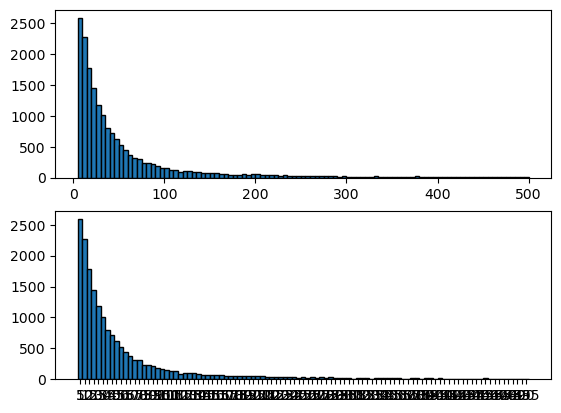

To get more in depth regression results, regressions are rerun for a few seperate data points

#### Regressions <a class="anchor" id="sub-bullet2.4.2"></a>

[Go back up](#top)

In [37]:
def run_twitvader(threshold=0, lag=1, rolling=1):
    custom_code = """
    #reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
    reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta

    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()
    
    
    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)
    
    # Add NT/RT ratio, column is 'NT/RT'
    df_input = nt_rt(df_input)
    
    # Filter out day-ticker combinations with less than 10 posts
    df_input = df_input[df_input[volume_col] > threshold]

    Stata.run(df_input, stata_code, echo=False)


In [38]:
run_twitvader(threshold=0)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mr
> ktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(ro
> bust) beta

Linear regression                               Number of obs     =     13,517
                                                F(587, 12929)     =       3.12
                                                Prob > F          =     0.0000
                                                R-squared         =     0.0984
     

      21444  |  -.0038969   .0034463    -1.13   0.258                -.0138379
      21445  |   .0009457   .0058907     0.16   0.872                 .0034274
      21446  |  -.0024634   .0060643    -0.41   0.685                -.0089274
      21447  |   .0018481   .0037831     0.49   0.625                 .0066975
      21448  |  -.0077245   .0054468    -1.42   0.156                -.0279942
      21451  |  -.0047929    .003353    -1.43   0.153                -.0170194
      21452  |  -.0015383    .003786    -0.41   0.685                -.0054624
      21453  |   -.003389   .0035574    -0.95   0.341                -.0120343
      21454  |  -.0021084   .0036227    -0.58   0.561                 -.007487
      21455  |  -.0007696   .0037385    -0.21   0.837                -.0027328
      21458  |  -.0041852   .0048514    -0.86   0.388                -.0148614
      21459  |  -.0076468   .0043907    -1.74   0.082                -.0271536
      21460  |  -.0012374   .0036766    -0.34   0.73

      21683  |   .0024824   .0036273     0.68   0.494                  .008815
      21684  |  -.0009205   .0033858    -0.27   0.786                -.0032685
      21685  |  -.0024856   .0033785    -0.74   0.462                -.0088262
      21686  |  -.0021742   .0033016    -0.66   0.510                -.0078793
      21689  |  -.0006323   .0034608    -0.18   0.855                -.0022453
      21690  |  -.0019758   .0033092    -0.60   0.550                -.0071604
      21691  |  -.0032053   .0032909    -0.97   0.330                -.0116162
      21692  |   -.002543   .0033009    -0.77   0.441                -.0092159
      21693  |  -.0019201   .0033227    -0.58   0.563                -.0069587
      21697  |  -.0005679   .0037166    -0.15   0.879                -.0019309
      21698  |  -.0012425   .0033977    -0.37   0.715                -.0044122
      21699  |   -.001574   .0032989    -0.48   0.633                -.0055891
      21700  |  -.0028262   .0032992    -0.86   0.39

      21859  |   -.002458   .0033416    -0.74   0.462                -.0087283
      21860  |  -.0032687   .0034843    -0.94   0.348                -.0116072
      21861  |  -.0027658   .0033267    -0.83   0.406                -.0098213
      21864  |  -.0003954   .0034809    -0.11   0.910                -.0014039
      21865  |  -.0019923   .0033605    -0.59   0.553                -.0072202
      21866  |  -.0009338   .0036335    -0.26   0.797                -.0033159
      21867  |  -.0007719   .0034274    -0.23   0.822                -.0027973
      21868  |  -.0027423   .0033487    -0.82   0.413                -.0099382
      21871  |  -.0025444   .0034477    -0.74   0.461                -.0088451
      21872  |  -.0026621    .003316    -0.80   0.422                -.0092543
      21873  |  -.0022941   .0032892    -0.70   0.486                 -.007975
      21874  |   -.002954   .0033241    -0.89   0.374                -.0102692
      21875  |  -.0017875   .0033941    -0.53   0.59

      22035  |  -.0002752   .0036906    -0.07   0.941                -.0009974
      22036  |   -.002267   .0036709    -0.62   0.537                -.0082159
      22039  |  -.0004389    .003453    -0.13   0.899                -.0015906
      22040  |     .00067   .0038151     0.18   0.861                 .0024282
      22041  |  -.0018918   .0035022    -0.54   0.589                 -.006856
      22042  |  -.0037122   .0034261    -1.08   0.279                -.0134534
      22043  |  -.0027463   .0034861    -0.79   0.431                -.0099528
      22046  |   .0069643    .003598     1.94   0.053                 .0242103
      22047  |  -.0015563   .0034012    -0.46   0.647                -.0055265
      22048  |    .001517    .003578     0.42   0.672                  .005387
      22049  |   .0024627   .0035004     0.70   0.482                 .0087448
      22050  |   .0014943   .0033879     0.44   0.659                 .0053061
      22053  |   .0034322   .0043623     0.79   0.43

In [40]:
run_twitvader(threshold=10)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mr
> ktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(ro
> bust) beta

Linear regression                               Number of obs     =     10,697
                                                F(587, 10109)     =       2.91
                                                Prob > F          =     0.0000
                                                R-squared         =     0.1231
     

      21399  |  -.0031016   .0042684    -0.73   0.467                -.0110091
      21402  |   .0001942   .0039783     0.05   0.961                 .0005828
      21403  |   .0001727    .004098     0.04   0.966                 .0005677
      21404  |  -.0041731   .0038885    -1.07   0.283                -.0148123
      21406  |  -.0006021    .004378    -0.14   0.891                 -.002137
      21409  |  -.0019252   .0035382    -0.54   0.586                -.0061494
      21410  |  -.0014528   .0038022    -0.38   0.702                -.0052776
      21411  |    .000395   .0040633     0.10   0.923                  .001402
      21412  |  -.0009951   .0046825    -0.21   0.832                 -.003615
      21413  |  -.0018533   .0038958    -0.48   0.634                -.0065781
      21416  |   .0002423   .0045149     0.05   0.957                 .0007271
      21417  |   .0053074   .0081941     0.65   0.517                 .0188385
      21418  |  -.0027547   .0039062    -0.71   0.48

      21641  |  -.0011783   .0040562    -0.29   0.771                -.0043766
      21642  |  -.0053261   .0035762    -1.49   0.136                -.0197828
      21643  |  -.0011168   .0052846    -0.21   0.833                -.0041482
      21644  |   -.003812   .0037067    -1.03   0.304                -.0138484
      21647  |   .0012695   .0041711     0.30   0.761                 .0034077
      21648  |  -.0021029   .0035094    -0.60   0.549                -.0072847
      21649  |  -.0033831   .0034893    -0.97   0.332                -.0122903
      21650  |  -.0022742   .0036621    -0.62   0.535                -.0078778
      21651  |   -.001903   .0041037    -0.46   0.643                -.0069132
      21654  |   .0006399   .0043927     0.15   0.884                 .0017176
      21655  |  -.0036755   .0037633    -0.98   0.329                -.0120798
      21656  |  -.0043147   .0035407    -1.22   0.223                -.0156746
      21657  |  -.0038212   .0035152    -1.09   0.27

      21816  |  -.0028123    .003698    -0.76   0.447                -.0094958
      21817  |  -.0024466   .0035044    -0.70   0.485                -.0088879
      21818  |  -.0030793   .0035962    -0.86   0.392                -.0101206
      21819  |    -.00259    .003548    -0.73   0.465                -.0085125
      21822  |  -.0027666   .0034483    -0.80   0.422                -.0071106
      21823  |  -.0030942   .0034349    -0.90   0.368                -.0104476
      21824  |  -.0032166   .0034968    -0.92   0.358                -.0116852
      21825  |  -.0026019   .0034674    -0.75   0.453                -.0092355
      21826  |  -.0030183   .0034598    -0.87   0.383                -.0107133
      21829  |    -.00289   .0035012    -0.83   0.409                -.0070822
      21830  |  -.0036813   .0035072    -1.05   0.294                -.0114081
      21831  |  -.0045806   .0035378    -1.29   0.195                -.0146311
      21832  |  -.0054765   .0035406    -1.55   0.12

      21979  |   .0008019   .0040547     0.20   0.843                 .0027078
      21980  |   .0001994    .003863     0.05   0.959                 .0007077
      21983  |  -.0033112   .0040789    -0.81   0.417                -.0085101
      21984  |   .0055127   .0042931     1.28   0.199                 .0195669
      21985  |   .0007351   .0045845     0.16   0.873                 .0026704
      21986  |  -.0024954   .0056171    -0.44   0.657                -.0090655
      21987  |   .0139001   .0059621     2.33   0.020                 .0504965
      21990  |   .0308537    .011586     2.66   0.008                 .0828194
      21991  |   .0098383   .0070839     1.39   0.165                 .0365422
      21992  |    .015686   .0088884     1.76   0.078                 .0556766
      21993  |   .0081928   .0058771     1.39   0.163                  .029763
      21994  |   .0144381     .00603     2.39   0.017                 .0524508
      21997  |   .0144007   .0062765     2.29   0.02

      22137  |   .0005832   .0037259     0.16   0.876                 .0021186
      22138  |  -.0015555   .0035175    -0.44   0.658                -.0057775
      22139  |   .0004613   .0038912     0.12   0.906                 .0016759
      22140  |  -.0023066   .0036179    -0.64   0.524                -.0083793
             |
       _cons |   -.008364   .0136331    -0.61   0.540                        .
------------------------------------------------------------------------------

. 
.     
. 


In [41]:
run_twitvader(threshold=50)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mr
> ktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(ro
> bust) beta

Linear regression                               Number of obs     =      4,558
                                                F(575, 3970)      =          .
                                                Prob > F          =          .
                                                R-squared         =     0.2173
     

      21635  |   .0007602    .003701     0.21   0.837                 .0019043
      21636  |  -.0080004   .0069462    -1.15   0.249                -.0200422
      21637  |  -.0083052   .0049282    -1.69   0.092                -.0208059
      21640  |  -.0046053   .0032722    -1.41   0.159                -.0097527
      21641  |  -.0011688   .0028128    -0.42   0.678                 -.002928
      21642  |  -.0068235   .0043015    -1.59   0.113                -.0193785
      21643  |     .00356   .0114074     0.31   0.755                 .0101102
      21644  |  -.0019832   .0033845    -0.59   0.558                -.0065014
      21647  |   .0067549   .0075112     0.90   0.369                 .0110829
      21648  |  -.0012845    .002684    -0.48   0.632                -.0036481
      21649  |  -.0011609   .0027395    -0.42   0.672                -.0029083
      21650  |   .0026656   .0035962     0.74   0.459                  .007138
      21651  |   .0037776   .0057123     0.66   0.50

      21838  |  -.0013795   .0028404    -0.49   0.627                -.0034558
      21839  |  -.0029901   .0028025    -1.07   0.286                  -.00895
      21840  |     .00009   .0026761     0.03   0.973                 .0002254
      21843  |   .0067215    .007439     0.90   0.366                 .0142342
      21844  |   .0025062   .0030592     0.82   0.413                 .0071176
      21845  |  -.0029381   .0048087    -0.61   0.541                -.0087944
      21846  |   -.006339   .0087817    -0.72   0.470                -.0180026
      21847  |   -.005977   .0033987    -1.76   0.079                -.0195938
      21850  |  -.0038971   .0047706    -0.82   0.414                 -.008253
      21851  |  -.0044249   .0041176    -1.07   0.283                 -.011085
      21852  |  -.0042944   .0030398    -1.41   0.158                -.0128541
      21853  |  -.0043557   .0027631    -1.58   0.115                  -.01237
      21854  |  -.0031964   .0029729    -1.08   0.28

      22026  |   .0075824   .0041642     1.82   0.069                 .0238012
      22027  |   .0013895   .0045102     0.31   0.758                  .004555
      22028  |  -.0056505   .0039115    -1.44   0.149                -.0160473
      22029  |  -.0025918   .0054832    -0.47   0.636                -.0077578
      22032  |  -.0002542   .0077228    -0.03   0.974                -.0005383
      22033  |   .0052827   .0032868     1.61   0.108                 .0187014
      22034  |  -.0022195   .0039861    -0.56   0.578                -.0081322
      22035  |   .0006888   .0038466     0.18   0.858                 .0023499
      22036  |  -.0023521    .003971    -0.59   0.554                -.0080248
      22039  |   .0014186   .0032767     0.43   0.665                 .0026873
      22040  |   .0029818   .0037394     0.80   0.425                  .009775
      22041  |  -.0004863    .003349    -0.15   0.885                -.0016593
      22042  |  -.0054682   .0030377    -1.80   0.07

In [42]:
run_twitvader(threshold=100)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mr
> ktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(ro
> bust) beta

Linear regression                               Number of obs     =      2,565
                                                F(497, 1977)      =          .
                                                Prob > F          =          .
                                                R-squared         =     0.3448
     

      21497  |   .0085782   .0065606     1.31   0.191                 .0266467
      21500  |   .0064659   .0039907     1.62   0.105                 .0094812
      21501  |   .0034349   .0038849     0.88   0.377                  .007959
      21502  |  -.0007565   .0050409    -0.15   0.881                -.0019198
      21503  |  -.0012815     .00542    -0.24   0.813                -.0029694
      21504  |   .0070151   .0078312     0.90   0.370                 .0178027
      21507  |  -.0005723   .0034979    -0.16   0.870                -.0005935
      21508  |  -.0004169   .0036997    -0.11   0.910                -.0010579
      21509  |   .0035727   .0033632     1.06   0.288                 .0097912
      21511  |   .0035675   .0034361     1.04   0.299                 .0052311
      21514  |    .000214   .0035254     0.06   0.952                 .0002219
      21515  |  -.0006405   .0036585    -0.18   0.861                -.0013278
      21516  |   .0006447   .0034272     0.19   0.85

      21717  |   .0005456   .0034341     0.16   0.874                 .0005658
      21718  |  -.0011564   .0047731    -0.24   0.809                -.0026795
      21719  |  -.0040335   .0040288    -1.00   0.317                -.0102361
      21720  |  -.0014767   .0049593    -0.30   0.766                -.0037475
      21721  |  -.0017269   .0032192    -0.54   0.592                -.0035797
      21724  |   .0045121   .0035315     1.28   0.202                 .0046793
      21725  |   .0017916   .0034363     0.52   0.602                  .001858
      21726  |   .0045057   .0043953     1.03   0.305                 .0104403
      21727  |   -.002198   .0034894    -0.63   0.529                -.0050931
      21728  |  -.0024396   .0045441    -0.54   0.591                -.0050571
      21731  |   .0015584   .0034131     0.46   0.648                 .0016162
      21732  |   -.002303   .0042895    -0.54   0.591                -.0041352
      21733  |  -.0024955   .0031468    -0.79   0.42

      21887  |  -.0006413   .0049123    -0.13   0.896                -.0013293
      21888  |   .0001486    .004534     0.03   0.974                  .000308
      21889  |   -.001364   .0036752    -0.37   0.711                -.0031606
      21892  |  -.0003048   .0034196    -0.09   0.929                -.0003161
      21893  |  -.0017265   .0035702    -0.48   0.629                -.0035789
      21894  |   -.014587   .0173099    -0.84   0.399                -.0337999
      21895  |  -.0056558   .0154861    -0.37   0.715                -.0155003
      21896  |    .002756   .0044128     0.62   0.532                 .0069941
      21899  |  -.0144451   .0034382    -4.20   0.000                -.0149805
      21900  |  -.0008038   .0037083    -0.22   0.828                -.0016661
      21901  |  -.0025853   .0039104    -0.66   0.509                -.0059904
      21902  |  -.0012069   .0034089    -0.35   0.723                -.0033076
      21903  |  -.0012204   .0034256    -0.36   0.72

      22062  |    .005006   .0053011     0.94   0.345                 .0146638
      22063  |   .0046118    .003867     1.19   0.233                  .017204
      22064  |   .0015181   .0041157     0.37   0.712                 .0041605
      22067  |   .0318721   .0041175     7.74   0.000                 .0330533
      22068  |   .0006045   .0041872     0.14   0.885                 .0012531
      22069  |   .0057799   .0043789     1.32   0.187                 .0146682
      22070  |   .0067164   .0061398     1.09   0.274                 .0170448
      22071  |   .0047479   .0045627     1.04   0.298                 .0110015
      22074  |   .0133243   .0054985     2.42   0.015                 .0195378
      22075  |    .005154   .0080612     0.64   0.523                 .0119425
      22076  |   .0216631   .0112594     1.92   0.054                 .0593696
      22077  |  -.0033517   .0045373    -0.74   0.460                 -.009818
      22078  |   .0212645   .0061419     3.46   0.00

In [43]:
run_twitvader(threshold=250)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mr
> ktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(ro
> bust) beta

Linear regression                               Number of obs     =      1,103
                                                F(338, 523)       =          .
                                                Prob > F          =          .
                                                R-squared         =     0.5424
     

      21403  |   .0078306     .00618     1.27   0.206                  .015806
      21404  |  -.0091411   .0091976    -0.99   0.321                -.0260703
      21406  |  -.0276868   .0093597    -2.96   0.003                -.0395348
      21409  |    .008478   .0044178     1.92   0.056                  .012106
      21410  |   .0000238   .0062831     0.00   0.997                  .000034
      21411  |  -.0055612   .0064144    -0.87   0.386                 -.007941
      21412  |  -.0051819   .0070509    -0.73   0.463                -.0073993
      21413  |   .0095931   .0158623     0.60   0.546                 .0237046
      21416  |   .0458275   .0045769    10.01   0.000                 .0654385
      21417  |  -.0036091    .007399    -0.49   0.626                -.0072849
      21418  |  -.0046359   .0063586    -0.73   0.466                -.0066198
      21419  |  -.0075793   .0093018    -0.81   0.416                -.0152986
      21420  |   .0157915   .0188194     0.84   0.40

      21602  |   .0175642   .0046754     3.76   0.000                 .0250804
      21605  |   .0027084   .0045505     0.60   0.552                 .0038674
      21606  |    .007662   .0071036     1.08   0.281                 .0154656
      21607  |  -.0444097   .0061345    -7.24   0.000                 -.063414
      21608  |  -.0027379   .0051772    -0.53   0.597                -.0039096
      21609  |   .0442013   .0409019     1.08   0.280                 .0892195
      21612  |   .0482847   .0045338    10.65   0.000                 .0689472
      21613  |   .0190589   .0211276     0.90   0.367                   .03847
      21614  |   .0134506   .0060571     2.22   0.027                 .0192066
      21615  |   .0079448   .0049501     1.60   0.109                 .0196316
      21616  |   .0078071   .0065151     1.20   0.231                 .0157585
      21619  |   .0004205   .0045136     0.09   0.926                 .0006005
      21620  |   .0384378    .040824     0.94   0.34

      21770  |   .0033568     .00467     0.72   0.473                 .0047933
      21773  |   .0054214   .0047495     1.14   0.254                 .0077414
      21774  |    .004117   .0051946     0.79   0.428                 .0058788
      21775  |   .0038907   .0073319     0.53   0.596                 .0078534
      21776  |   .0065431   .0046385     1.41   0.159                 .0093432
      21777  |   .0010781   .0076416     0.14   0.888                 .0026641
      21781  |   .0049461   .0052746     0.94   0.349                 .0070628
      21782  |   .0076761   .0045368     1.69   0.091                 .0109609
      21783  |   .0017429    .004483     0.39   0.698                 .0024887
      21784  |   .0045049   .0046722     0.96   0.335                 .0064327
      21787  |   .0086653   .0059412     1.46   0.145                 .0123735
      21788  |   .0027802   .0045185     0.62   0.539                   .00397
      21789  |   .0044041   .0047536     0.93   0.35

      21976  |   .0174128   .0052086     3.34   0.001                 .0248643
      21977  |   .0266116   .0106901     2.49   0.013                 .0537149
      21978  |   .0068886   .0082447     0.84   0.404                 .0139045
      21979  |  -.0002881   .0057382    -0.05   0.960                -.0004114
      21980  |   .0111447   .0053426     2.09   0.037                 .0159139
      21983  |   .0060104   .0052876     1.14   0.256                 .0085825
      21984  |   .0140942   .0067783     2.08   0.038                  .028449
      21985  |  -.0021701   .0049781    -0.44   0.663                -.0043803
      21986  |   .0208265   .0359743     0.58   0.563                 .0420378
      21987  |   .0322602   .0163374     1.97   0.049                 .0920051
      21990  |    .019901   .0051855     3.84   0.000                 .0284172
      21991  |   .0325137   .0361018     0.90   0.368                 .0927282
      21992  |   .0618056   .0558143     1.11   0.26


. 
.     
. 


In [44]:
run_twitvader(threshold=500)


. gen date_numeric = date(date, "YMD")

. format date_numeric %td

. 
. encode rhticker, gen(company_num)

. #xtset company_num date_numeric
Unknown #command
. tsset company_num date_numeric

Panel variable: company_num (unbalanced)
 Time variable: date_numeric, 02may2018 to 31aug2020, but with gaps
         Delta: 1 day

. 
.     #reg NTRT twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crsplog_mr
> ktcap_control taqprice_control i.company_num i.date_numeric, vce(robust) beta
Unknown #command
.     reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crsplog_mrktcap_control taqprice_control i.company_num i.date_numeric, vce(ro
> bust) beta

Linear regression                               Number of obs     =        595
                                                F(141, 127)       =          .
                                                Prob > F          =          .
                                                R-squared         =     0.7693
     

      21670  |   .0023773   .0175202     0.14   0.892                 .0056794
      21671  |   .0081298   .0206603     0.39   0.695                 .0194219
      21672  |   .0079169   .0103449     0.77   0.446                 .0133849
      21675  |   .0043125   .0015048     2.87   0.005                 .0072911
      21676  |   .0067314   .0022028     3.06   0.003                 .0113806
      21677  |   .0155231   .0043311     3.58   0.000                 .0262447
      21678  |   .0100249    .002362     4.24   0.000                  .016949
      21679  |   .0133094   .0037952     3.51   0.001                  .022502
      21683  |   .0180695   .0051779     3.49   0.001                 .0305499
      21684  |   .0124299   .0028408     4.38   0.000                  .021015
      21686  |   .0197392   .0029087     6.79   0.000                 .0333728
      21690  |   .0165071   .0118851     1.39   0.167                 .0279083
      21691  |    .017727   .0110117     1.61   0.11

      21958  |  -.0129002   .0268726    -0.48   0.632                -.0308184
      21959  |  -.0062667   .0132487    -0.47   0.637                -.0105951
      21963  |  -.0024437   .0113501    -0.22   0.830                -.0058379
      21964  |  -.0086842   .0113715    -0.76   0.446                -.0207463
      21965  |  -.0053593   .0148302    -0.36   0.718                -.0090609
      21966  |   .0007025    .012554     0.06   0.955                 .0011877
      21970  |  -.0128437   .0129585    -0.99   0.324                -.0217147
      21971  |   .0004104   .0150393     0.03   0.978                 .0009804
      21972  |  -.0252721   .0109265    -2.31   0.022                -.0427272
      21973  |   .0157027   .0149057     1.05   0.294                 .0265484
      21977  |   .0210485   .0153003     1.38   0.171                 .0355864
      21978  |   .0029533   .0117021     0.25   0.801                 .0049931
      21979  |  -.0051653   .0112594    -0.46   0.64


. 
.     
. 


### Market cap <a class="anchor" id="sub-bullet2.5"></a>

[Go back up](#top)

Both market cap and post limit can affect the regression results.

In [39]:
def grab_coefficients(df_input, stata_code, ticker, lag, rolling, marketcaps, marketcaps_rank, average_daily_posts):
    Stata.run(df_input, stata_code)
    print("Now running 'grab_coefficients'")

    r = stata.get_return()
    coefficients = r['r(PT)']
    
    e = stata.get_ereturn()
    
    # Coefficients
    pos = 0
    sentiment = coefficients[0][pos]
    volume = coefficients[1][pos]
    interact = coefficients[2][pos]
    marketcap_control = coefficients[3][pos]
    stockprice_control = coefficients[4][pos]
    r2 = e['e(r2)']
    
    # p-values
    pos = 3
    sentiment_p = coefficients[0][pos]
    volume_p = coefficients[1][pos]
    interact_p = coefficients[2][pos]
    marketcap_control_p = coefficients[3][pos]
    stockprice_control_p = coefficients[4][pos]
    
    result = [ticker, marketcaps[ticker], marketcaps_rank[ticker], average_daily_posts[ticker], sentiment, volume, interact, marketcap_control, stockprice_control, r2, sentiment_p, volume_p, interact_p, marketcap_control_p, stockprice_control_p]
    print(f"Now returning coefficients: {result}")
    return result

def regression(stata_code, df, ticker, lag, rolling, sentiment_col, volume_col, interaction_col, marketcaps, marketcaps_rank, average_daily_posts):
    print("Now running 'regression'")
    df_input = df.copy()

    # Lag and/or rolling
    lagged_cols=[sentiment_col, volume_col, interaction_col]
    df_input = change_cols(df_input, lagged_cols, lag=lag, rolling=rolling)

    result = grab_coefficients(df_input, stata_code, ticker, lag, rolling, marketcaps, marketcaps_rank, average_daily_posts)
    
    return result

def repeat_reg(stata_code, df, sentiment_col, volume_col, interaction_col, lag=1, rolling=1):
    print("Now running 'repeat_reg'")
    # Creating empty df
    result_df = pd.DataFrame(columns=['ticker', 'marketcap', 'marketcap_rank', 'daily_posts', 'sentiment', 'volume', 'interact', 'marketcap_control', 'stockprice_control', 'r2', 'sentiment_p', 'volume_p', 'interact_p', 'marketcap_control_p', 'stockprice_control_p'])
    # create a list of dataframes to concatenate
    results = []
    
    ticker_list = ['AAPL', 'AMD', 'AMZN', 'ATVI', 'BA', 'BABA', 'BAC', 'DIS', 'F', 'GE', 'GME', 'IQ', 'LULU', 'MSFT', 'MU', 'NFLX', 'NVDA', 'SBUX', 'SHOP', 'SNAP', 'SQ', 'TLRY', 'TSLA', 'V', 'WMT']
    # Marketcap info
    marketcaps = df.groupby('[rh]ticker').mean()['[crsp]mrktcap']
    marketcaps_rank = df.groupby('[rh]ticker').mean()['[crsp]mrktcap'].rank()
    average_daily_posts = df.groupby('[rh]ticker').mean()['[twit][f2s2]total']
    
    for ticker in ticker_list:
        df_input = df[df['[rh]ticker'] == ticker].copy()
        
        result = regression(stata_code, df_input, ticker, lag, rolling, sentiment_col, volume_col, interaction_col, marketcaps, marketcaps_rank, average_daily_posts)
        results.append(pd.DataFrame([result], columns=result_df.columns))
        print("Saved results to list")
        
    
                   
    # concatenate the dataframes
    result_df = pd.concat(results, ignore_index=True)
    
    return result_df
    

**Twitter**

In [35]:
def show_scatter(csv_path, x, y, annotate=True):
    df = pd.read_csv(csv_path)

    # Create the scatter plot
    ax = df.plot.scatter(x=x, y=y)

    # Add labels to the scatter plot
    if annotate:
        for i, row in df.iterrows():
            ax.annotate(row['ticker'], (row[x] + 0.3, row[y]))

    # Show the plot
    plt.show()


In [ ]:
# Calculating marketcap results for Twitter - VADER
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_twitvader.csv"

if save:
    custom_code = """
    reg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap_control taqprice_control, vce(robust)
    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2s2]method_1'
    volume_col = '[twit][f2s2]total'
    interaction_col = '[f2s2]interact_sent_vol'

    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, df_input, sentiment_col, volume_col, interaction_col, lag=1, rolling=1)

    result_df.to_csv(save_path, index=False)


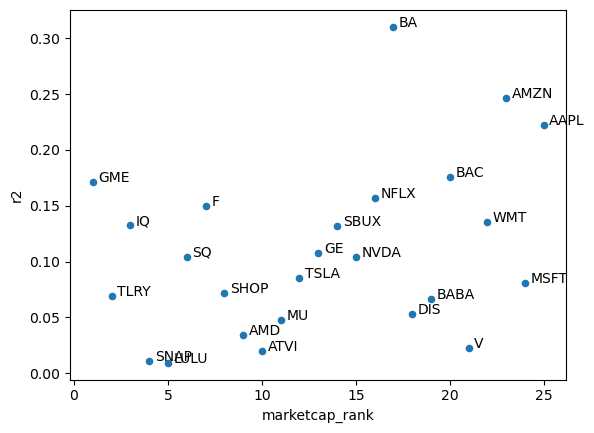

In [112]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_twitvader.csv"
show_scatter(csv_path, x='marketcap_rank', y='r2')

In [ ]:
# Calculating marketcap results for Twitter - finBERT
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_twitfinbert.csv"

if save:
    custom_code = """
    reg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 twitf2BERTmethod_1 twitf2BERTtotal f2BERTinteract_sent_vol crspmrktcap_control taqprice_control, vce(robust)
    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[twit][f2BERT]method_1'
    volume_col = '[twit][f2BERT]total'
    interaction_col = '[f2BERT]interact_sent_vol'
    
    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, df_input, sentiment_col, volume_col, interaction_col, lag=1, rolling=1)

    result_df.to_csv(save_path, index=False)


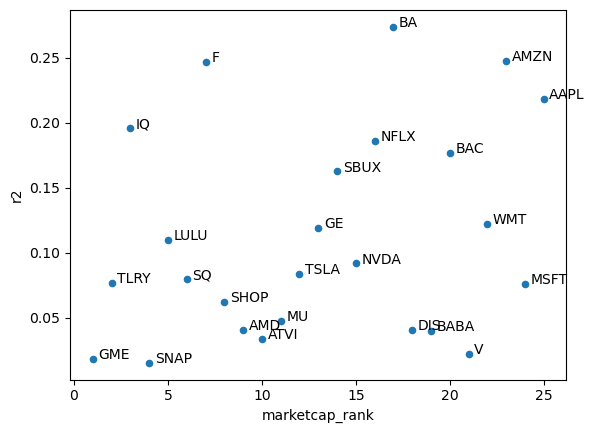

In [49]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_twitfinbert.csv"
show_scatter(csv_path, x='marketcap_rank', y='r2')

In [ ]:
# Calculating marketcap results for Reddit - VADER
save = False
save_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_redvader.csv"

if save:
    custom_code = """
    reg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control, vce(robust) beta
    """
    custom_code2 = """areg rhperformance_1 redm2f2s2method_1 redm2f2s2total m2f2s2interact_sent_vol crspmrktcap_control taqprice_control, vce(robust)
    """
    stata_code = stata_code_base + custom_code

    df_input = get_regression_df().copy()

    sentiment_col = '[red][m2f2s2]method_1'
    volume_col = '[red][m2f2s2]total'
    interaction_col = '[m2f2s2]interact_sent_vol'
    
    # Creating interaction term
    df_input[interaction_col] = df_input[sentiment_col] * df_input[volume_col]

    result_df = repeat_reg(stata_code, df_input, sentiment_col, volume_col, interaction_col, lag=1, rolling=1)

    result_df.to_csv(save_path, index=False)


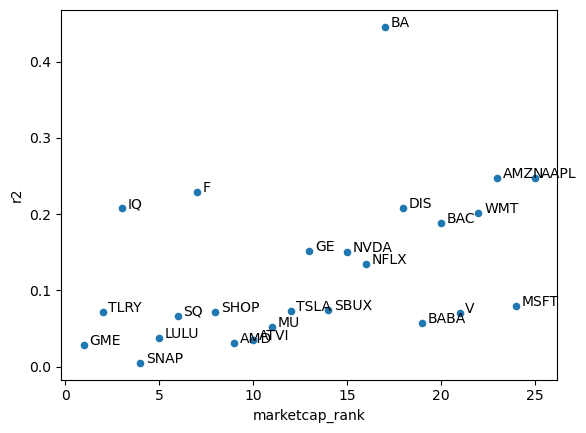

In [46]:
csv_path = r"E:\Users\Christiaan\Large_Files\Thesis\results\marketcap_redvader.csv"
show_scatter(csv_path, x='marketcap_rank', y='r2')

In [89]:
datalist = [[-1.12170673e-03,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03], [123,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03], [456,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03]]
r['r(table)'][0]
r['r(table)'][3]
import pandas as pd

# create an empty dataframe
df = pd.DataFrame(columns=['value_1', 'value_2', 'value_3', 'value_4', 'value_5'])

# create a list of dataframes to concatenate
dfs = []
for data in datalist:
    dfs.append(pd.DataFrame([data], columns=df.columns))

# concatenate the dataframes
df = pd.concat(dfs, ignore_index=True)
df

value_1  value_2   value_3       value_4   value_5
0   -0.001122  0.00001 -0.000012  1.182742e-12  0.001747
1  123.000000  0.00001 -0.000012  1.182742e-12  0.001747
2  456.000000  0.00001 -0.000012  1.182742e-12  0.001747

In [104]:
stata_code = """regress rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol crspmrktcap"""
# run(df, stata_code)
Stata.run(df, stata_code)

. regress rhperformance_1 twitf2s2method_1 twitf2s2total f2s2interact_sent_vol 
> crspmrktcap

      Source |       SS           df       MS      Number of obs   =       561
-------------+----------------------------------   F(4, 556)       =     34.17
       Model |  .004987974         4  .001246994   Prob > F        =    0.0000
    Residual |  .020291878       556  .000036496   R-squared       =    0.1973
-------------+----------------------------------   Adj R-squared   =    0.1915
       Total |  .025279853       560  .000045143   Root MSE        =    .00604

------------------------------------------------------------------------------
rhperforma~1 | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
twitf2s2me~1 |   .0054165   .0034884     1.55   0.121    -.0014356    .0122687
twitf2s2to~l |   .0000104   6.30e-06     1.65   0.101    -2.01e-06    .0000228
f2s2intera~l |  -.0000138   9.36e-0

In [103]:
import os
os.chdir("C:/Program Files/Stata17/utilities")
from pystata import config
config.init("mp")

from pystata import stata

# # Setup Stata
# import stata_setup
# stata_setup.config("C:/Program Files/Stata17", "mp")

# from pystata import stata
# # stata.config.status()




## Vault

[Go back up](#top)

In [56]:
def add_marketcap(results_df, ticker):
    # Path
    csv_path = r"C:\Users\Ck0rt\Documents\Large files\School\MSc Finance & Investments\Thesis\market_cap_info.csv"
    
    # Read csv
    df = pd.read_csv(csv_path)
    
    # Rename twitter columns to contain [crsp]
    df.rename(columns={"Ticker": "ticker", "DlyCalDt": "date", "DlyCap": "[crsp]mrktcap"}, inplace=True)
    
    # Filter observations for ticker
    df = df[df['ticker'] == ticker].reset_index(drop=True)
    
    # Drop ticker column to prevent duplicate
    df.drop(columns=['ticker'], inplace=True)

    # Merge data
    results_df = results_df.merge(df, how='left', left_on='date', right_on='date')

    return results_df


Loop files and add marktcap info

In [58]:
file_dir = r"C:\Users\Ck0rt\Documents\Large files\School\MSc Finance & Investments\Thesis\MERGED_DATA"
ticker_list = ['AAPL', 'AMD', 'AMZN', 'ATVI', 'BA', 'BABA', 'BAC', 'DIS', 'F', 'GE', 'GME', 'IQ', 'LULU', 'MSFT', 'MU', 'NFLX', 'NVDA', 'SBUX', 'SHOP', 'SNAP', 'SQ', 'TLRY', 'TSLA', 'V', 'WMT']

save = False

if save:
    for ticker in ticker_list:
        # file path
        file_path = os.path.join(file_dir, f"{ticker}.csv").replace('\\', '/')

        # Read csv
        merged_df = pd.read_csv(file_path)
        
        # Add files
        df = add_marketcap(merged_df, ticker)


        df.to_csv(file_path, encoding='utf-8', index=False)
        print(f"Merged file saved at: {file_path}")

Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/AAPL.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/AMD.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/AMZN.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/ATVI.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/BA.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/BABA.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/BAC.csv
Merged file saved at: C:/Users/Ck0rt/Documents/Large files/School/MSc Finance & Investments/Thesis/MERGED_DATA/DIS.csv
Merged file saved at: C:/Users/Ck0rt/Document

In [58]:
csv_path = join_paths(working_dir, "Thesis\DATA_MERGED", "AAPL.csv")
df = pd.read_csv(csv_path)

columns = ['[twit][f2s2]method_1', '[twit][f2s2]total', '[twit][f2s2]rel_vol', '[crsp]mrktcap']
df[columns] = df[columns].shift(1)
df.dropna(inplace=True)
df['[f2s2]interact_sent_vol'] = df['[twit][f2s2]method_1'] * df['[twit][f2s2]total']
df[['date', '[rh]performance_1', '[twit][f2s2]method_1', '[twit][f2s2]total', '[twit][f2s2]rel_vol', '[f2s2]interact_sent_vol', '[crsp]mrktcap']]

date  [rh]performance_1  [twit][f2s2]method_1  [twit][f2s2]total  \
7    2018-05-08          -0.003110              0.746914              324.0   
8    2018-05-09          -0.000739              0.607955              176.0   
9    2018-05-10           0.000816              0.673077              104.0   
14   2018-05-15          -0.001767              0.666667               87.0   
15   2018-05-16          -0.000028              0.576923              130.0   
..          ...                ...                   ...                ...   
828  2020-08-06           0.017180              0.787815              476.0   
829  2020-08-07           0.012765              0.792222              900.0   
833  2020-08-11           0.010803              0.654717              530.0   
834  2020-08-12           0.016233              0.641243              354.0   
835  2020-08-13           0.016899              0.721739              345.0   

     [twit][f2s2]rel_vol  [f2s2]interact_sent_vol  [crsp]mrktcap  
7               0.493580                    242.0   9.100870e+08  
8               0.395633                    107.0   9.144614e+08  
9               0.349832                     70.0   9.209003e+08  
14              0.657667                     58.0   9.247832e+08  
15              1.034091                     75.0   9.163783e+08  
..                   ...                      ...            ...  
828             0.506845                    375.0   1.882348e+09  
829             1.071064                    713.0   1.948022e+09  
833             0.959897                    347.0   1.927926e+09  
834             0.717221                    227.0   1.870590e+09  
835             0.726534                    249.0   1.932758e+09  

[427 rows x 7 columns]

In [21]:
import pystata
import pandas as pd

stata.pdataframe_to_data(get_regression_df(), True)
stata_code = """#regress rhperformance_1 twitf2s2method_1 twitf2s2total crspmrktcap, vce(robust) beta
summarize rhperformance_1 twitf2s2method_1"""

# Run the regression and capture the output in a string
stata.run(stata_code, echo=True)
# regression_output = pystata.run_statamc(stata_code)

# Convert the output to a pandas DataFrame
# regression_results = pd.read_csv(StringIO(regression_output), delim_whitespace=True, skiprows=1)

# Process the regression results here
# r = stata.get_return()['r(table)']
print()
r = stata.get_return()
e = stata.get_ereturn()


. #regress rhperformance_1 twitf2s2method_1 twitf2s2total crspmrktcap, vce(robu
> st) beta
Unknown #command
. summarize rhperformance_1 twitf2s2method_1

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
rhperforma~1 |     13,970    .0014372    .0109256  -.1122662   .2452852
twitf2s2me~1 |     20,617    .6992524    .1845037          0          1

. 



In [108]:
r['r(PT)'][1][0]


6.010338902176173e-06

In [101]:
printed_values

'Hello, world!\n42\n'

In [ ]:
val1 = -.0026394 # coefficients
val2 = .1845037 # stdev indep
val3 = .0109256 # stdev dep

(val1 * val2) / val3

In [109]:
def get_stdev(var):
    var = var.replace('[', '').replace(']', '')
    # Get stdev
    stata_code = """summarize """ + var
    Stata.run(df, stata_code, echo=False)
    r = stata.get_return()
    stdev = r['r(sd)']
    return stdev

def get_beta(indep_name, indep_coeff, dep_stdev):
    # Get stdev of indep variable
    indep_stdev = get_stdev(indep_name)
    
    # Calc beta
    beta = (indep_coeff * indep_stdev) / dep_stdev
    return beta


sentiment_col = '[twit][f2s2]method_1'
volume_col = '[twit][f2s2]total'
interaction_col = '[f2s2]interact_sent_vol'

sentiment_coeff = -0.0026393820126851143
volume_coeff = 6.010338902176173e-06
dep_var_stdev = get_stdev("[rh]performance_1")
get_beta(sentiment_col, sentiment_coeff, dep_var_stdev)
get_beta(volume_col, volume_coeff, dep_var_stdev)

# get_beta(interaction_col, dep_var_stdev)


0.1567844788001796

In [84]:
# Coefficient(independent_var) * stdev(independent_var) / stdev(dependent_var)
r

{'r(N)': 20617.0,
 'r(sum_w)': 20617.0,
 'r(mean)': 0.6992523760676094,
 'r(Var)': 0.03404160149842623,
 'r(sd)': 0.18450366256100778,
 'r(min)': 0.0,
 'r(max)': 1.0,
 'r(sum)': 14416.486237385901}

In [76]:
coefficients = r['r(PT)']
# Coefficients
pos = 0
sentiment = coefficients[0][pos]
volume = coefficients[1][pos]
interact = coefficients[2][pos]
marketcap_control = coefficients[3][pos]
stockprice_control = coefficients[4][pos]

# p-values
pos = 3
sentiment_p = coefficients[0][pos]
volume_p = coefficients[1][pos]
interact_p = coefficients[2][pos]
marketcap_control_p = coefficients[3][pos]
stockprice_control_p = coefficients[4][pos]

print(sentiment, volume, interact, sentiment, marketcap_control, stockprice_control, sentiment_p, volume_p, interact_p)


0 0 0 0 1.1827423360894773e-12 0.0017466365477976343 0.04099282554273676 1.551517577469717e-06 0.00016834299608004712


numpy.float64

In [88]:
def grab_coefficients():
    r = stata.get_return()
    e = stata.get_ereturn()
    
    r2 = e['e(r2)']
r['r(table)'][3]
# r['r(PT)']

array([4.09928255e-02, 1.55151758e-06, 1.68342996e-04, 4.59339498e-05,
       1.42210189e-05])

In [84]:
datalist = [[-1.12170673e-03,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03], [123,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03], [456,  1.02939798e-05, -1.20817539e-05,
         1.18274234e-12,  1.74663655e-03]]
r['r(table)'][0]
r['r(table)'][3]
import pandas as pd

# create an empty dataframe
df = pd.DataFrame(columns=['value_1', 'value_2', 'value_3', 'value_4', 'value_5'])

# create a list of dataframes to concatenate
dfs = []
for data in datalist:
    dfs.append(pd.DataFrame([data], columns=df.columns))

# concatenate the dataframes
df = pd.concat(dfs, ignore_index=True)
df

value_1  value_2   value_3       value_4   value_5
0   -0.001122  0.00001 -0.000012  1.182742e-12  0.001747
1  123.000000  0.00001 -0.000012  1.182742e-12  0.001747
2  456.000000  0.00001 -0.000012  1.182742e-12  0.001747

In [52]:
r

{'r(PT_has_legend)': 0.0,
 'r(PT_has_cnotes)': 0.0,
 'r(PT_k_ctitles)': 1.0,
 'r(level)': 95.0,
 'r(PT_rseps)': '`""\' `""\' `""\' `""\' `""\'',
 'r(PT_rnotes)': '`""\' `""\' `""\' `""\' `""\'',
 'r(PT_raligns)': '`"right"\' `"right"\' `"right"\' `"right"\' `"right"\'',
 'r(PT_rtitles)': '`"twitf2s2me~1"\' `"twitf2s2to~l"\' `"f2s2intera~l"\' `"crspmrktcap"\' `"_cons"\'',
 'r(PT_cformats)': '`"%9.0g"\' `"%9.0g"\' `"%8.2f"\' `"%5.3f"\' `"%9.0g"\' `"%9.0g"\'',
 'r(PT_cspans1)': '`"1"\' `"1"\' `"1"\' `"1"\' `"2"\' `"0"\'',
 'r(PT_ctitles1)': '`"Coefficient"\' `"Std. err."\' `"t"\' `"P>|t|"\' `"[95% conf. interval]"\' `""\'',
 'r(PT_corner1)': 'rhperforma~1',
 'r(put_tables)': 'PT',
 'r(citype)': 'normal',
 'r(_collect_prefix_get)': 'ignore',
 'r(PT)': array([[-1.12170673e-03,  5.48834539e-04, -2.04379763e+00,
          4.09928255e-02, -2.19749869e-03, -4.59147665e-05],
        [ 1.02939798e-05,  2.14162664e-06,  4.80661738e+00,
          1.55151758e-06,  6.09609402e-06,  1.44918657e-05],
 

In [77]:
import pandas as pd
from pystata import stata

def run(dataframe, commands):
    # Convert Pandas DataFrame to Stata dataset
    stata.pdataframe_to_data(dataframe, True)

    # Execute Stata commands
    stata.run(commands, echo=True)

    # Print processed instructions
    print(f"Stata processed the following instructions\n"
          f"----------------------------------------\n"
          f"{commands}"
          f"----------------------------------------")


In [123]:
csv_path = r"C:\Users\Ck0rt\Documents\Large files\School\MSc Finance & Investments\Thesis\MERGED_DATA\AAPL.csv"
df = pd.read_csv(csv_path)

columns = ['[twit][f2s2]method_1', '[twit][f2s2]total', '[twit][f2s2]rel_vol', '[crsp]mrktcap']
df[columns] = df[columns].shift(1)
df.dropna(inplace=True)
df['[f2s2]interact_sent_vol'] = df['[twit][f2s2]method_1'] * df['[twit][f2s2]total']
df[['date', '[rh]performance_1', '[twit][f2s2]method_1', '[twit][f2s2]total', '[twit][f2s2]rel_vol', '[f2s2]interact_sent_vol', '[crsp]mrktcap']]

date  [rh]performance_1  [twit][f2s2]method_1  [twit][f2s2]total  \
1    2018-05-08          -0.003110              0.746914              324.0   
2    2018-05-09          -0.000739              0.607955              176.0   
3    2018-05-10           0.000816              0.673077              104.0   
5    2018-05-14           0.000028              0.694118              170.0   
6    2018-05-15          -0.001767              0.666667               87.0   
..          ...                ...                   ...                ...   
556  2020-08-07           0.012765              0.792222              900.0   
557  2020-08-10           0.022062              0.765583              738.0   
558  2020-08-11           0.010803              0.654717              530.0   
559  2020-08-12           0.016233              0.641243              354.0   
560  2020-08-13           0.016899              0.721739              345.0   

     [twit][f2s2]rel_vol  [f2s2]interact_sent_vol  [crsp]mrktcap  
1               0.493580                    242.0   9.100870e+08  
2               0.395633                    107.0   9.144614e+08  
3               0.349832                     70.0   9.209003e+08  
5               0.855500                    118.0   9.269459e+08  
6               0.657667                     58.0   9.247832e+08  
..                   ...                      ...            ...  
556             1.071064                    713.0   1.948022e+09  
557             1.186768                    565.0   1.900306e+09  
558             0.959897                    347.0   1.927926e+09  
559             0.717221                    227.0   1.870590e+09  
560             0.726534                    249.0   1.932758e+09  

[548 rows x 7 columns]

In [254]:
df = df_input.copy()
col = ['date', '[rh]ticker','[rh]performance_1', '[taq]bs_change', '[twit][f2s2]method_1', '[twit][f2s2]total']
df = df[col]

df = scale_01(df, '[rh]performance_1', name_prefix="scal_")
df = scale_01(df, '[taq]bs_change', name_prefix="scal_")

# Subtracting average
df['scal_[rh]performance_1'] = df['scal_[rh]performance_1'] - df['scal_[rh]performance_1'].mean()
df['scal_[taq]bs_change'] = df['scal_[taq]bs_change'] - df['scal_[taq]bs_change'].mean()
df['NT/RT'] = (1 + df['scal_[rh]performance_1']) / (1 + df['scal_[taq]bs_change']) - 1

df.head(20)

date [rh]ticker  [rh]performance_1  [taq]bs_change  \
0  2018-05-01       AAPL                NaN             NaN   
1  2018-05-02       AAPL                NaN             NaN   
2  2018-05-03       AAPL                NaN             NaN   
3  2018-05-04       AAPL                NaN             NaN   
4  2018-05-05       AAPL                NaN             NaN   
5  2018-05-06       AAPL                NaN             NaN   
6  2018-05-07       AAPL          -0.000588          0.0356   
7  2018-05-08       AAPL          -0.003110         -0.0275   
8  2018-05-09       AAPL          -0.000739         -0.0124   
9  2018-05-10       AAPL           0.000816          0.0388   
10 2018-05-11       AAPL          -0.000369          0.0551   
11 2018-05-12       AAPL                NaN             NaN   
12 2018-05-13       AAPL                NaN             NaN   
13 2018-05-14       AAPL           0.000028         -0.0327   
14 2018-05-15       AAPL          -0.001767          0.0117   
15 2018-05-16       AAPL          -0.000028         -0.0234   
16 2018-05-17       AAPL           0.001906          0.0328   
17 2018-05-18       AAPL          -0.000867         -0.0637   
18 2018-05-19       AAPL                NaN             NaN   
19 2018-05-20       AAPL                NaN             NaN   

    [twit][f2s2]method_1  [twit][f2s2]total  scal_[rh]performance_1  \
0               0.714544             1657.0                     NaN   
1               0.770449             1137.0                     NaN   
2               0.673152              257.0                     NaN   
3               0.748284              874.0                     NaN   
4               0.763485              241.0                     NaN   
5               0.714286              105.0                     NaN   
6               0.746914              324.0               -0.113241   
7               0.607955              176.0               -0.149717   
8               0.673077              104.0               -0.115425   
9               0.763838              271.0               -0.092938   
10              0.694118              170.0               -0.110075   
11              0.647887               71.0                     NaN   
12              0.765957               47.0                     NaN   
13              0.666667               87.0               -0.104330   
14              0.576923              130.0               -0.130298   
15              0.629630              135.0               -0.105148   
16              0.663717              113.0               -0.077182   
17              0.594595               74.0               -0.117284   
18              0.577778               45.0                     NaN   
19              0.640000               25.0                     NaN   

    scal_[taq]bs_change     NT/RT  
0                   NaN       NaN  
1                   NaN       NaN  
2                   NaN       NaN  
3                   NaN       NaN  
4                   NaN       NaN  
5                   NaN       NaN  
6              0.005980 -0.118512  
7             -0.132276 -0.020100  
8             -0.099191 -0.018022  
9              0.012991 -0.104570  
10             0.048705 -0.151406  
11                  NaN       NaN  
12                  NaN       NaN  
13            -0.143670  0.045940  
14            -0.046387 -0.087993  
15            -0.123293  0.020696  
16            -0.000155 -0.077039  
17            -0.211593  0.119619  
18                  NaN       NaN  
19                  NaN       NaN

In [240]:
df = df_input.copy()
col = ['date', '[rh]ticker','[rh]performance_1', '[taq]bs_change', '[twit][f2s2]method_1', '[twit][f2s2]total']
df = df[df['[rh]ticker'] == "AAPL"][col]
df.dropna(inplace=True)

# # Taking log value
# col_name = '[rh]performance_1'
# df[f"{col_name}"] = np.log(1+df[col_name])
# col_name = '[taq]bs_change'
# df[f"{col_name}"] = np.log(1+df[col_name])


# Taking scaled value
df = scale_01(df, '[rh]performance_1', name_prefix="scal_")
df = scale_01(df, '[taq]bs_change', name_prefix="scal_")

# Subtracting average
df['scal_[rh]performance_1'] = df['scal_[rh]performance_1'] - df['scal_[rh]performance_1'].mean()
df['scal_[taq]bs_change'] = df['scal_[taq]bs_change'] - df['scal_[taq]bs_change'].mean()

df['NT/RT'] = (1 + df['scal_[rh]performance_1']) / (1 + df['scal_[taq]bs_change']) - 1


cols = ['scal_[rh]performance_1', 'scal_[taq]bs_change', 'NT/RT']
# df[cols] = df[cols].rolling(30).mean()
df[['scal_[rh]performance_1', 'scal_[taq]bs_change', 'NT/RT']].dropna().plot()


date [rh]ticker  [rh]performance_1  [taq]bs_change  \
6  2018-05-07       AAPL          -0.000588          0.0356   
7  2018-05-08       AAPL          -0.003110         -0.0275   
8  2018-05-09       AAPL          -0.000739         -0.0124   
9  2018-05-10       AAPL           0.000816          0.0388   
10 2018-05-11       AAPL          -0.000369          0.0551   
13 2018-05-14       AAPL           0.000028         -0.0327   
14 2018-05-15       AAPL          -0.001767          0.0117   
15 2018-05-16       AAPL          -0.000028         -0.0234   
16 2018-05-17       AAPL           0.001906          0.0328   
17 2018-05-18       AAPL          -0.000867         -0.0637   
20 2018-05-21       AAPL          -0.002156         -0.0550   
21 2018-05-22       AAPL           0.002266         -0.0128   
22 2018-05-23       AAPL          -0.001912          0.0141   
23 2018-05-24       AAPL           0.001792          0.0327   
24 2018-05-25       AAPL          -0.002146         -0.0764   
28 2018-05-29       AAPL          -0.000091          0.1037   
29 2018-05-30       AAPL           0.003430         -0.0321   
30 2018-05-31       AAPL          -0.002115         -0.0514   
31 2018-06-01       AAPL          -0.005194         -0.1588   
34 2018-06-04       AAPL           0.003249          0.0756   

    [twit][f2s2]method_1  [twit][f2s2]total  scal_[rh]performance_1  \
6               0.746914              324.0                0.192404   
7               0.607955              176.0                0.155928   
8               0.673077              104.0                0.190220   
9               0.763838              271.0                0.212707   
10              0.694118              170.0                0.195571   
13              0.666667               87.0                0.201315   
14              0.576923              130.0                0.175348   
15              0.629630              135.0                0.200497   
16              0.663717              113.0                0.228463   
17              0.594595               74.0                0.188361   
20              0.566265               83.0                0.169725   
21              0.825000              120.0                0.233672   
22              0.706897              116.0                0.173252   
23              0.697842              139.0                0.226816   
24              0.690476              126.0                0.169872   
28              0.653465              101.0                0.199583   
29              0.544643              112.0                0.250503   
30              0.565789               76.0                0.170321   
31              0.745223              157.0                0.125796   
34              0.753906              512.0                0.247895   

    scal_[taq]bs_change  
6              0.425942  
7              0.287686  
8              0.320771  
9              0.432954  
10             0.468668  
13             0.276293  
14             0.373576  
15             0.296670  
16             0.419807  
17             0.208370  
20             0.227432  
21             0.319895  
22             0.378834  
23             0.419588  
24             0.180543  
28             0.575153  
29             0.277607  
30             0.235320  
31             0.000000  
34             0.513585